<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

## Prepare Environment

Jupyter notebook housekeeping

In [1]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

### Install local canswim package

In [2]:
# pip install -r requirements.txt
# !pip install -e ./

import sys
!{sys.executable} -m pip install -e ./




Obtaining file:///home/ivelin/canswim
  Preparing metadata (setup.py) ... done


  Attempting uninstall: canswim
    Found existing installation: canswim 0.0.1
    Uninstalling canswim-0.0.1:
      Successfully uninstalled canswim-0.0.1
  Running setup.py develop for canswim


Check whether GPU is available

In [3]:
import torch
torch.cuda.is_available()

True

## Config Training Parameters

In [4]:
import random
import pandas as pd

n_stocks = 100 # -1 for all, otherwise a number like 300
n_epochs = 5 # model training epochs

# pick the earlies date after which market data is available for all covariate series
train_date_start = pd.Timestamp('1991-01-01')

# How far back should the model look in order to make a prediction
train_history = 252*2 # 252 days in a year with market data
# How far into the future should the model forecast
pred_horizon = 21*2 # 21 days in a month with market data


In [5]:

n_test_range_days = train_history+3*pred_horizon
print(f'n_test_range_days: {n_test_range_days}')


# minimum amount of historical data required to train on a stock series
# stocks that are too new off IPOs, are not a good fit for training this model
min_samples = n_test_range_days*3
print(f'min_samples: {min_samples}')

n_test_range_days: 630
min_samples: 1890


## Load Target Series Data

Load data from prepared local csv files

In [6]:
from darts import TimeSeries
import pandas as pd


Load price history
* Then split into target series and past covariates

In [7]:
stocks_price_file = 'data/all_stocks_price_hist.csv.bz2'

In [8]:

from canswim import target_series

ticker_dict = target_series.load_stock_prices(csv_file=stocks_price_file, min_samples=min_samples)



In [9]:
stock_tickers = list(set(ticker_dict.keys()))

len(stock_tickers)


1855

In [10]:
# reduce ticker set to a workable size for the training loop
stock_tickers = random.sample(stock_tickers, n_stocks)

In [11]:
print(list(stock_tickers))

['HMN', 'FWRD', 'CNMD', 'REG', 'RIGL', 'SANM', 'ENV', 'TIMB', 'DK', 'FPI', 'BXP', 'FRPH', 'ITW', 'HTH', 'NWFL', 'DFS', 'MODN', 'HZO', 'MRNS', 'TRST', 'PPL', 'MFA', 'ASGN', 'TRN', 'LADR', 'IOSP', 'NWE', 'BA', 'WWW', 'ETR', 'TBPH', 'TGT', 'CDP', 'NAT', 'MDLZ', 'PATK', 'CPE', 'PCH', 'TYL', 'BDC', 'SUPN', 'FSS', 'CBAN', 'STT', 'NFBK', 'SFM', 'JRVR', 'MSFT', 'SLAB', 'ORCL', 'LWLG', 'DRH', 'QNST', 'DCOM', 'WTW', 'CECO', 'Z', 'VRNT', 'SMBC', 'SAVA', 'ETN', 'KEYS', 'TITN', 'BRT', 'CCRD', 'UFPT', 'PTCT', 'NVEC', 'ACIC', 'ALLE', 'XPRO', 'TMUS', 'VATE', 'NVO', 'NVRI', 'CASS', 'JBLU', 'OKE', 'AMSF', 'UCBI', 'HLIO', 'KVHI', 'NVGS', 'GRMN', 'ASB', 'BKD', 'MET', 'HOFT', 'SYNA', 'VTR', 'WRB', 'ATO', 'TSQ', 'JNJ', 'SVC', 'TRUP', 'SGMO', 'TOWN', 'AXGN', 'HBCP']


In [12]:
print(stock_tickers[0])

HMN


In [13]:

from canswim import target_series

ticker_train_dict = dict((k, ticker_dict[k]) for k in stock_tickers)
ticker_series = target_series.prepare_ticker_series(ticker_dict=ticker_train_dict, train_date_start=train_date_start)


Preparing ticker series for 100 stocks.


Ticker series dict created.
ticker: HMN gaps: 
      gap_start    gap_end  gap_size
0   1991-11-28 1991-11-28         1
1   1991-12-25 1991-12-25         1
2   1992-01-01 1992-01-01         1
3   1992-02-17 1992-02-17         1
4   1992-04-17 1992-04-17         1
..         ...        ...       ...
283 2023-09-04 2023-09-04         1
284 2023-11-23 2023-11-23         1
285 2023-12-25 2023-12-25         1
286 2024-01-01 2024-01-01         1
287 2024-01-15 2024-01-15         1

[288 rows x 3 columns]
ticker: FWRD gaps: 
      gap_start    gap_end  gap_size
0   1993-11-25 1993-11-25         1
1   1993-12-24 1993-12-24         1
2   1994-02-21 1994-02-21         1
3   1994-04-01 1994-04-01         1
4   1994-04-27 1994-04-27         1
..         ...        ...       ...
267 2023-09-04 2023-09-04         1
268 2023-11-23 2023-11-23         1
269 2023-12-25 2023-12-25         1
270 2024-01-01 2024-01-01         1
271 2024-01-15 2024-01-15         1

[272 rows x 3 columns]
ticker: CNMD gaps: 

Prepare multiple series - one per stock ticker

In [14]:
ticker_series

{'HMN': <TimeSeries (DataArray) (Date: 8397, component: 7, sample: 1)>
 array([[[9.00000000e+00],
         [9.18750000e+00],
         [9.00000000e+00],
         ...,
         [4.20737314e+00],
         [6.09340000e+06],
         [0.00000000e+00]],
 
        [[9.00000000e+00],
         [9.00000000e+00],
         [8.75000000e+00],
         ...,
         [4.20737314e+00],
         [8.11800000e+05],
         [0.00000000e+00]],
 
        [[8.87500000e+00],
         [8.87500000e+00],
         [8.68750000e+00],
         ...,
 ...
         ...,
         [3.37200012e+01],
         [1.52900000e+05],
         [0.00000000e+00]],
 
        [[3.39799995e+01],
         [3.40400009e+01],
         [3.36899986e+01],
         ...,
         [3.40200005e+01],
         [1.69000000e+05],
         [0.00000000e+00]],
 
        [[3.42299995e+01],
         [3.47700005e+01],
         [3.41800003e+01],
         ...,
         [3.47200012e+01],
         [5.48730000e+04],
         [0.00000000e+00]]])
 Coordinates:
  

In [15]:
from darts.dataprocessing.transformers import Scaler

# scale series values within [0,1] range to avoid gradient explosion
#for t, series in ticker_series.items():
#    ser_scaler = Scaler(verbose=True, n_jobs=-1)
#    series_scaled = ser_scaler.fit_transform(series=series)
#    # print(f'ticker: {t} , {series_scaled}')
#    ticker_series[t] = series_scaled
#    print(f'ticker: {t} , {ticker_series[t]}')


In [16]:
# prepare target univariate series for Close price
# target_series = {t: ticker_series[t].univariate_component('Close') for t in ticker_series.keys()}

target_columns = ['Open', 'Close']

def drop_non_target_columns(series):
    cols = series.columns
    non_target_columns = list(set(cols) - set(target_columns))
    new_series = series.drop_columns(col_names=non_target_columns)
    # print(f'dropped non-target columns: {non_target_columns}')
    return new_series

# prepare target multivariate series for Open, Close and Volume
target_series = {t: drop_non_target_columns(s) for t,s in ticker_series.items()}

target_series

{'HMN': <TimeSeries (DataArray) (Date: 8397, component: 2, sample: 1)>
 array([[[ 9.        ],
         [ 9.        ]],
 
        [[ 9.        ],
         [ 9.        ]],
 
        [[ 8.875     ],
         [ 8.8125    ]],
 
        ...,
 
        [[33.25999832],
         [33.72000122]],
 
        [[33.97999954],
         [34.02000046]],
 
        [[34.22999954],
         [34.72000122]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1991-11-15 1991-11-18 ... 2024-01-22
   * component  (component) object 'Open' 'Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'FWRD': <TimeSeries (DataArray) (Date: 7875, component: 2, sample: 1)>
 array([[[ 3.38888907],
         [ 3.55555606]],
 
        [[ 3.61111093],
         [ 3.83333302]],
 
        [[ 3.88888907],
         [ 3.77777791]],
 
        ...,
 
        [[53.15999985],
         [52.47000122]],
 
        [[52.77999878],
         [51.29999924]],
 
        [[51.5

Prepare Past Covariates

Target Stock's price history: Open, High, Low and Volume

In [17]:
# start with target ticker's own adjacent data: Open, High, Low, Volume
# drop Close which is the target series
# drop holidays which will be added later to future covariates
past_covariates = {t: ticker_series[t].drop_columns(col_names=target_columns + ['holidays']) for t in ticker_series.keys()}

past_covariates


{'HMN': <TimeSeries (DataArray) (Date: 8397, component: 4, sample: 1)>
 array([[[9.18750000e+00],
         [9.00000000e+00],
         [4.20737314e+00],
         [6.09340000e+06]],
 
        [[9.00000000e+00],
         [8.75000000e+00],
         [4.20737314e+00],
         [8.11800000e+05]],
 
        [[8.87500000e+00],
         [8.68750000e+00],
         [4.11972189e+00],
         [2.35000000e+05]],
 
        ...,
 
        [[3.37599983e+01],
         [3.30600014e+01],
         [3.37200012e+01],
         [1.52900000e+05]],
 
        [[3.40400009e+01],
         [3.36899986e+01],
         [3.40200005e+01],
         [1.69000000e+05]],
 
        [[3.47700005e+01],
         [3.41800003e+01],
         [3.47200012e+01],
         [5.48730000e+04]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1991-11-15 1991-11-18 ... 2024-01-22
   * component  (component) object 'High' 'Low' 'Adj Close' 'Volume'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hie

In [18]:
past_covariates.keys()

dict_keys(['HMN', 'FWRD', 'CNMD', 'REG', 'RIGL', 'SANM', 'ENV', 'TIMB', 'DK', 'FPI', 'BXP', 'FRPH', 'ITW', 'HTH', 'NWFL', 'DFS', 'MODN', 'HZO', 'MRNS', 'TRST', 'PPL', 'MFA', 'ASGN', 'TRN', 'LADR', 'IOSP', 'NWE', 'BA', 'WWW', 'ETR', 'TBPH', 'TGT', 'CDP', 'NAT', 'MDLZ', 'PATK', 'CPE', 'PCH', 'TYL', 'BDC', 'SUPN', 'FSS', 'CBAN', 'STT', 'NFBK', 'SFM', 'JRVR', 'MSFT', 'SLAB', 'ORCL', 'LWLG', 'DRH', 'QNST', 'DCOM', 'WTW', 'CECO', 'Z', 'VRNT', 'SMBC', 'SAVA', 'ETN', 'KEYS', 'TITN', 'BRT', 'CCRD', 'UFPT', 'PTCT', 'NVEC', 'ACIC', 'ALLE', 'XPRO', 'TMUS', 'VATE', 'NVO', 'NVRI', 'CASS', 'JBLU', 'OKE', 'AMSF', 'UCBI', 'HLIO', 'KVHI', 'NVGS', 'GRMN', 'ASB', 'BKD', 'MET', 'HOFT', 'SYNA', 'VTR', 'WRB', 'ATO', 'TSQ', 'JNJ', 'SVC', 'TRUP', 'SGMO', 'TOWN', 'AXGN', 'HBCP'])

HMN past covariates components: Index(['High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
FWRD past covariates components: Index(['High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
CNMD past covariates components: Index(['High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
REG past covariates components: Index(['High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')


Text(0, 0.5, 'Past Covariates')

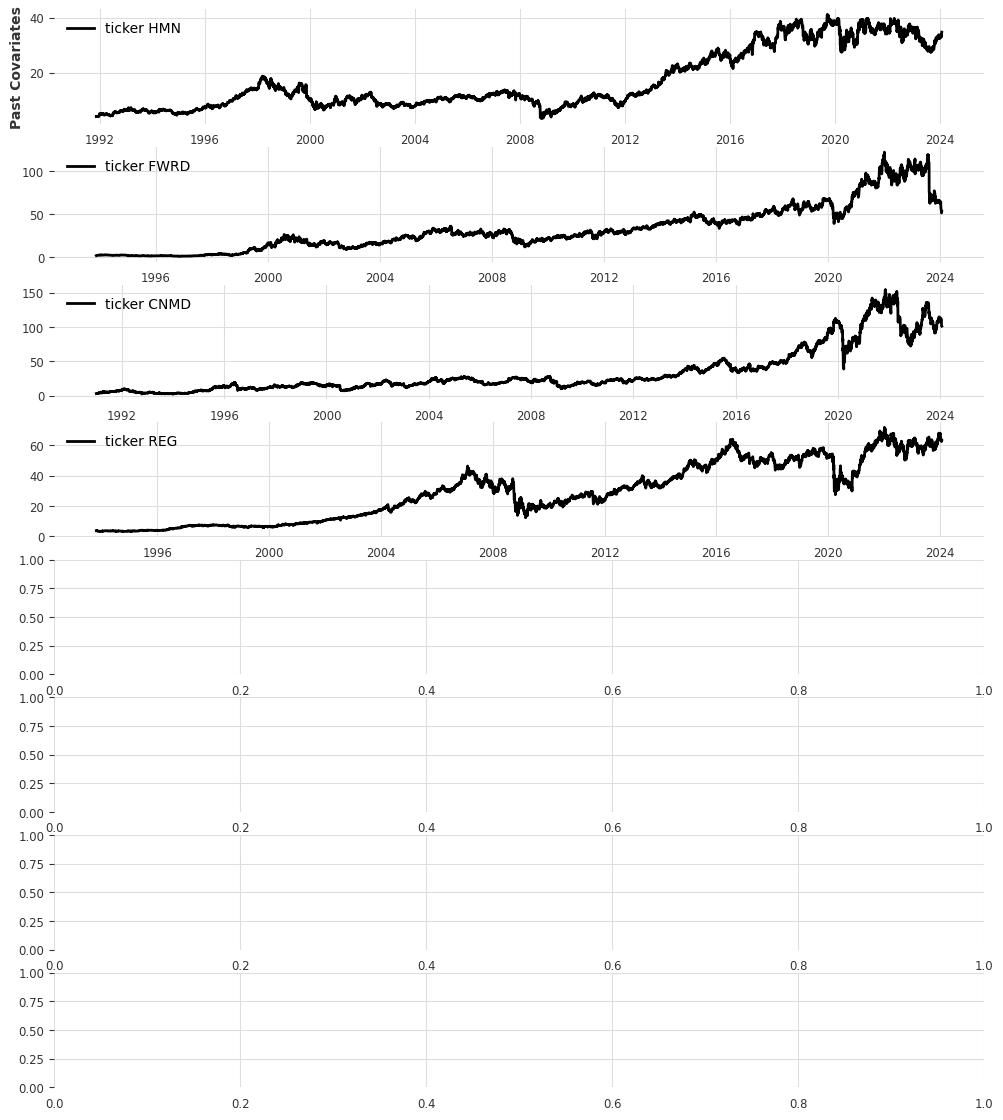

In [19]:
import matplotlib.pyplot as plt


n_plot_samples = 4
# plot sample of past covariates
fig, axes = plt.subplots(nrows=n_plot_samples*2, ncols=1, figsize=(12, 14))
for i,t in enumerate(past_covariates.keys()):
    if i < n_plot_samples:
        print(f'{t} past covariates components: {past_covariates[t].columns}')
        past_covariates[t].univariate_component('Adj Close').plot(label=f'ticker {t} ', ax=axes[i])
        # past_covariates[t].univariate_component('Volume').plot(label=f'ticker {t} Volume ', ax=axes[n_plot_samples+i])

axes[0].set_ylabel('Past Covariates')


## Prepare Past Covariates

### Add sales and earnings calendar (past and forward looking) to past covariates
* Note: Research further if the data feed provides forward looking estimates at early enough dates to be seen by the model during training. It appears that some forward looking estimates are provided with a date column with value after the actual date they have become avaible.

In [20]:
import pandas as pd

earnings_loaded_df = pd.read_csv('data/earnings_calendar.csv.bz2')
print(earnings_loaded_df)

       symbol        date     eps  epsEstimated time       revenue  \
0          CF  2024-10-31     NaN           NaN  amc           NaN   
1          CF  2024-08-08     NaN           NaN  amc           NaN   
2          CF  2024-05-02     NaN           NaN  amc           NaN   
3          CF  2024-02-14     NaN          1.56  bmo           NaN   
4          CF  2023-11-01  0.8500          0.94  amc  1.273000e+09   
...       ...         ...     ...           ...  ...           ...   
214890    GPI  1998-04-21  0.2000          0.17  bmo  2.539000e+08   
214891    GPI  1998-02-17  0.1500          0.15  bmo  2.132000e+08   
214892    GPI  1997-09-30  0.2422           NaN  bmo  2.387000e+08   
214893    GPI  1997-06-30  0.1900           NaN  bmo  2.252000e+08   
214894    GPI  1997-03-31  0.1800           NaN  bmo  2.252000e+08   

        revenueEstimated updatedFromDate fiscalDateEnding  
0                    NaN      2024-01-22       2024-09-30  
1                    NaN      2024-01-2

In [21]:
earnings_loaded_df.index.is_unique

True

In [22]:
earnings_loaded_df.index

RangeIndex(start=0, stop=214895, step=1)

In [23]:
len(earnings_loaded_df.index)

214895

In [24]:
earnings_loaded_df['date'] = pd.to_datetime(earnings_loaded_df['date'])

In [25]:
earnings_unique = earnings_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [26]:
assert not earnings_unique.duplicated().any()

In [27]:
earnings_unique

symbol       date     eps  epsEstimated time       revenue  \
0          CF 2024-10-31     NaN           NaN  amc           NaN   
1          CF 2024-08-08     NaN           NaN  amc           NaN   
2          CF 2024-05-02     NaN           NaN  amc           NaN   
3          CF 2024-02-14     NaN          1.56  bmo           NaN   
4          CF 2023-11-01  0.8500          0.94  amc  1.273000e+09   
...       ...        ...     ...           ...  ...           ...   
214890    GPI 1998-04-21  0.2000          0.17  bmo  2.539000e+08   
214891    GPI 1998-02-17  0.1500          0.15  bmo  2.132000e+08   
214892    GPI 1997-09-30  0.2422           NaN  bmo  2.387000e+08   
214893    GPI 1997-06-30  0.1900           NaN  bmo  2.252000e+08   
214894    GPI 1997-03-31  0.1800           NaN  bmo  2.252000e+08   

        revenueEstimated updatedFromDate fiscalDateEnding  
0                    NaN      2024-01-22       2024-09-30  
1                    NaN      2024-01-22       2024-06-30  
2                    NaN      2024-01-22       2024-03-30  
3           1.500270e+09      2024-01-22       2023-12-30  
4           1.300920e+09      2024-01-22       2023-09-30  
...                  ...             ...              ...  
214890      2.158150e+08      2023-12-04       1998-03-31  
214891      1.679000e+08      2023-12-04       1997-12-31  
214892               NaN      2023-12-04       1997-09-30  
214893               NaN      2023-12-04       1997-06-30  
214894               NaN      2023-12-04       1997-03-31  

[214801 rows x 9 columns]

In [28]:
earnings_unique = earnings_unique.set_index(keys=['symbol', 'date'])

In [29]:
earnings_unique

eps  epsEstimated time       revenue  revenueEstimated  \
symbol date                                                                    
CF     2024-10-31     NaN           NaN  amc           NaN               NaN   
       2024-08-08     NaN           NaN  amc           NaN               NaN   
       2024-05-02     NaN           NaN  amc           NaN               NaN   
       2024-02-14     NaN          1.56  bmo           NaN      1.500270e+09   
       2023-11-01  0.8500          0.94  amc  1.273000e+09      1.300920e+09   
...                   ...           ...  ...           ...               ...   
GPI    1998-04-21  0.2000          0.17  bmo  2.539000e+08      2.158150e+08   
       1998-02-17  0.1500          0.15  bmo  2.132000e+08      1.679000e+08   
       1997-09-30  0.2422           NaN  bmo  2.387000e+08               NaN   
       1997-06-30  0.1900           NaN  bmo  2.252000e+08               NaN   
       1997-03-31  0.1800           NaN  bmo  2.252000e+08               NaN   

                  updatedFromDate fiscalDateEnding  
symbol date                                         
CF     2024-10-31      2024-01-22       2024-09-30  
       2024-08-08      2024-01-22       2024-06-30  
       2024-05-02      2024-01-22       2024-03-30  
       2024-02-14      2024-01-22       2023-12-30  
       2023-11-01      2024-01-22       2023-09-30  
...                           ...              ...  
GPI    1998-04-21      2023-12-04       1998-03-31  
       1998-02-17      2023-12-04       1997-12-31  
       1997-09-30      2023-12-04       1997-09-30  
       1997-06-30      2023-12-04       1997-06-30  
       1997-03-31      2023-12-04       1997-03-31  

[214801 rows x 7 columns]

In [30]:
assert earnings_unique.index.has_duplicates == False

In [31]:
# check if data for a given symbol was saved and loaded as expected
earnings_unique.xs('LRN', level='symbol')

eps  epsEstimated time      revenue  revenueEstimated  \
date                                                                    
2024-10-22      NaN           NaN  amc          NaN               NaN   
2024-08-13      NaN           NaN  amc          NaN               NaN   
2024-04-23      NaN           NaN  amc          NaN               NaN   
2024-01-23      NaN          1.34  amc          NaN       500850000.0   
2023-10-24  0.11000         -0.35  amc  480181000.0       451150000.0   
...             ...           ...  ...          ...               ...   
2006-06-30  0.17150           NaN  amc   29225000.0               NaN   
2006-03-31  0.17200           NaN  amc   29226000.0               NaN   
2005-12-31  0.17200           NaN  amc   29226000.0               NaN   
2005-09-30  0.17200           NaN  amc   29226000.0               NaN   
2001-06-30  0.00066           NaN  amc  455211000.0               NaN   

           updatedFromDate fiscalDateEnding  
date                                         
2024-10-22      2024-01-22       2024-09-30  
2024-08-13      2024-01-22       2024-06-30  
2024-04-23      2024-01-22       2024-03-30  
2024-01-23      2024-01-22       2023-12-30  
2023-10-24      2024-01-22       2023-09-30  
...                    ...              ...  
2006-06-30      2023-12-04       2006-06-30  
2006-03-31      2023-12-04       2006-03-31  
2005-12-31      2023-12-04       2005-12-31  
2005-09-30      2023-12-04       2005-09-30  
2001-06-30      2023-12-04       2001-06-30  

[78 rows x 7 columns]

In [32]:
print(earnings_unique.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated updatedFromDate fiscalDateEnding
date                                                                                               
2024-10-22   NaN           NaN  amc          NaN               NaN      2024-01-22       2024-09-30
2024-08-13   NaN           NaN  amc          NaN               NaN      2024-01-22       2024-06-30
2024-04-23   NaN           NaN  amc          NaN               NaN      2024-01-22       2024-03-30
2024-01-23   NaN        1.3400  amc          NaN      5.008500e+08      2024-01-22       2023-12-30
2023-10-24  0.11       -0.3500  amc  480181000.0      4.511500e+08      2024-01-22       2023-09-30
2023-08-15  1.01        0.8700  amc  483489000.0      4.607000e+08      2023-12-04       2023-06-30
2023-04-25  1.30        1.0700  amc  470284000.0      4.607000e+08      2023-12-04       2023-03-31
2023-01-24  1.19        1.0400  amc  458435000.0               NaN      2023-12-04       2022-12-31


In [33]:
# get a clean deep copy so it is easier to debug further data cleanup steps
earnings_expanded_df = earnings_unique.copy()

In [34]:
# convert date strings to numerical representation
ufd = pd.to_datetime(earnings_expanded_df['updatedFromDate'])
ufd_year = ufd.dt.year
ufd_month = ufd.dt.month
ufd_day = ufd.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_year', value=ufd_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_month', value=ufd_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_day', value=ufd_day)
earnings_expanded_df.pop('updatedFromDate')


symbol  date      
CF      2024-10-31    2024-01-22
        2024-08-08    2024-01-22
        2024-05-02    2024-01-22
        2024-02-14    2024-01-22
        2023-11-01    2024-01-22
                         ...    
GPI     1998-04-21    2023-12-04
        1998-02-17    2023-12-04
        1997-09-30    2023-12-04
        1997-06-30    2023-12-04
        1997-03-31    2023-12-04
Name: updatedFromDate, Length: 214801, dtype: object

In [35]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated fiscalDateEnding  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year
date                                                                                                                                                 
2024-10-22   NaN           NaN  amc          NaN               NaN       2024-09-30                   22                      1                  2024
2024-08-13   NaN           NaN  amc          NaN               NaN       2024-06-30                   22                      1                  2024
2024-04-23   NaN           NaN  amc          NaN               NaN       2024-03-30                   22                      1                  2024
2024-01-23   NaN        1.3400  amc          NaN      5.008500e+08       2023-12-30                   22                      1                  2024
2023-10-24  0.11       -0.3500  amc  480181000.0      4.511500e+08       2023-09-30                 

In [36]:
# convert date strings to numerical representation
fde = pd.to_datetime(earnings_expanded_df['fiscalDateEnding'])
fde_year = fde.dt.year
fde_month = fde.dt.month
fde_day = fde.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_year', value=fde_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_month', value=fde_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_day', value=fde_day)
earnings_expanded_df.pop('fiscalDateEnding')


symbol  date      
CF      2024-10-31    2024-09-30
        2024-08-08    2024-06-30
        2024-05-02    2024-03-30
        2024-02-14    2023-12-30
        2023-11-01    2023-09-30
                         ...    
GPI     1998-04-21    1998-03-31
        1998-02-17    1997-12-31
        1997-09-30    1997-09-30
        1997-06-30    1997-06-30
        1997-03-31    1997-03-31
Name: fiscalDateEnding, Length: 214801, dtype: object

In [37]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                     
2024-10-22   NaN           NaN  amc          NaN               NaN                   22                      1                  2024                    30                       9                   2024
2024-08-13   NaN           NaN  amc          NaN               NaN                   22                      1                  2024                    30                       6                   2024
2024-04-23   NaN           NaN  amc          NaN               NaN                   22                      1                  2024                    30                       3              

In [38]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
earnings_expanded_df['time'] = earnings_expanded_df['time'].replace(['bmo', 'amc', '--', 'dmh'],
                        [0, 1, -1, -1], inplace=False).astype('int32')



In [39]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated  time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                      
2024-10-22   NaN           NaN     1          NaN               NaN                   22                      1                  2024                    30                       9                   2024
2024-08-13   NaN           NaN     1          NaN               NaN                   22                      1                  2024                    30                       6                   2024
2024-04-23   NaN           NaN     1          NaN               NaN                   22                      1                  2024                    30                       3         

In [40]:
from darts import TimeSeries

type(earnings_expanded_df.index)

pandas.core.indexes.multi.MultiIndex

In [41]:
earnings_expanded_df.index.names

FrozenList(['symbol', 'date'])

In [42]:
earnings_expanded_df.dtypes

eps                       float64
epsEstimated              float64
time                        int32
revenue                   float64
revenueEstimated          float64
updatedFromDate_day         int32
updatedFromDate_month       int32
updatedFromDate_year        int32
fiscalDateEnding_day        int32
fiscalDateEnding_month      int32
fiscalDateEnding_year       int32
dtype: object

In [43]:
# credit for implementation: https://stackoverflow.com/a/39068260/12015435
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))


In [44]:
t_earn = earnings_expanded_df.loc[['LRN']]
t_earn = t_earn.droplevel('symbol')
t_earn.index = pd.to_datetime(t_earn.index)
print(f'index type for {t}: {type(t_earn.index)}')
assert not t_earn.index.duplicated().any()

for i in t_earn.index:
    if not is_business_day(i):
        print(f'earnings record date is not a business day: \n{t_earn.loc[[i]]}')



index type for HBCP: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
earnings record date is not a business day: 
               eps  epsEstimated  time     revenue  revenueEstimated  \
date                                                                   
2007-09-30  0.1201           NaN     1  27196000.0               NaN   

            updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  \
date                                                                           
2007-09-30                    4                     12                  2023   

            fiscalDateEnding_day  fiscalDateEnding_month  \
date                                                       
2007-09-30                    30                       9   

            fiscalDateEnding_year  
date                               
2007-09-30                   2007  
earnings record date is not a business day: 
                eps  epsEstimated  time     revenue  revenueEstimated  \
date           

In [45]:
len(t_earn.index)

78

In [46]:
# align all dates with Business days
from pandas.tseries.offsets import BDay

def to_biz_day(date=None, report_time=None):
    if not is_business_day(date):
        if report_time == 1 or report_time =='amc':
                return date-BDay(n=1)
        else: 
            return date+BDay(n=1)
    else:
         return date

def align_to_business_days(t_earn=None):
    assert not t_earn.index.isnull().any()
    new_index = t_earn.index.map(lambda x : to_biz_day(date=x, report_time=t_earn.at[x, 'time']))
    t_earn.index = new_index
    if t_earn.index.isnull().any():
         print(t_earn[t_earn.index.isnull()])
    for i in t_earn.index:
        assert is_business_day(i)
    return t_earn


In [47]:
# backfill quarterly earnigs and revenue estimates so that the model can see the next quarter's estimates during the previou s quarter days

def back_fill_earn_estimates(t_earn=None):
    t_earn['time'].bfill(inplace=True)
    t_earn['epsEstimated'].bfill(inplace=True)
    t_earn['revenueEstimated'].bfill(inplace=True)
    t_earn['fiscalDateEnding_day'].bfill(inplace=True)
    t_earn['fiscalDateEnding_month'].bfill(inplace=True)
    t_earn['fiscalDateEnding_year'].bfill(inplace=True)
    return t_earn



In [48]:
# convert earnings dataframe to series

t_earn_series = {}
for t in list(ticker_series.keys()):
    # print(f'ticker: {t}')
    t_earn = earnings_expanded_df.loc[[t]].copy()
    t_earn = t_earn.droplevel('symbol')
    t_earn.index = pd.to_datetime(t_earn.index)
    # print(f'index type for {t}: {type(t_earn.index)}')
    assert not t_earn.index.duplicated().any()
    assert not t_earn.index.isnull().any()
    t_earn = align_to_business_days(t_earn)
    # print(f't_earn freq: {t_earn.index}')
    tes_tmp = TimeSeries.from_dataframe(t_earn, freq='B', fill_missing_dates=True)
    t_earn = back_fill_earn_estimates(t_earn=tes_tmp.pd_dataframe())
    tes = TimeSeries.from_dataframe(t_earn, fillna_value=-1)
    assert len(tes.gaps()) == 0
    t_earn_series[t] = tes


In [49]:
t

'HBCP'

In [50]:
t_earn


component      eps  epsEstimated  time    revenue  revenueEstimated  \
date                                                                  
2007-04-02  0.1099          0.39  -1.0  4398067.0      1.425357e+07   
2007-04-03     NaN          0.39  -1.0        NaN      1.425357e+07   
2007-04-04     NaN          0.39  -1.0        NaN      1.425357e+07   
2007-04-05     NaN          0.39  -1.0        NaN      1.425357e+07   
2007-04-06     NaN          0.39  -1.0        NaN      1.425357e+07   
...            ...           ...   ...        ...               ...   
2024-10-10     NaN           NaN   1.0        NaN               NaN   
2024-10-11     NaN           NaN   1.0        NaN               NaN   
2024-10-14     NaN           NaN   1.0        NaN               NaN   
2024-10-15     NaN           NaN   1.0        NaN               NaN   
2024-10-16     NaN           NaN   1.0        NaN               NaN   

component   updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  \
date                                                                           
2007-04-02                  4.0                   12.0                2023.0   
2007-04-03                  NaN                    NaN                   NaN   
2007-04-04                  NaN                    NaN                   NaN   
2007-04-05                  NaN                    NaN                   NaN   
2007-04-06                  NaN                    NaN                   NaN   
...                         ...                    ...                   ...   
2024-10-10                  NaN                    NaN                   NaN   
2024-10-11                  NaN                    NaN                   NaN   
2024-10-14                  NaN                    NaN                   NaN   
2024-10-15                  NaN                    NaN                   NaN   
2024-10-16                 22.0                    1.0                2024.0   

component   fiscalDateEnding_day  fiscalDateEnding_month  \
date                                                       
2007-04-02                  31.0                     3.0   
2007-04-03                  30.0                     6.0   
2007-04-04                  30.0                     6.0   
2007-04-05                  30.0                     6.0   
2007-04-06                  30.0                     6.0   
...                          ...                     ...   
2024-10-10                  30.0                     9.0   
2024-10-11                  30.0                     9.0   
2024-10-14                  30.0                     9.0   
2024-10-15                  30.0                     9.0   
2024-10-16                  30.0                     9.0   

component   fiscalDateEnding_year  
date                               
2007-04-02                 2007.0  
2007-04-03                 2007.0  
2007-04-04                 2007.0  
2007-04-05                 2007.0  
2007-04-06                 2007.0  
...                           ...  
2024-10-10                 2024.0  
2024-10-11                 2024.0  
2024-10-14                 2024.0  
2024-10-15                 2024.0  
2024-10-16                 2024.0  

[4578 rows x 11 columns]

In [51]:
print(t_earn.tail(n=330).to_string(index=True))

component    eps  epsEstimated  time     revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                     
2023-07-13   NaN          1.16   1.0         NaN        30590000.0                  NaN                    NaN                   NaN                  30.0                     6.0                 2023.0
2023-07-14   NaN          1.16   1.0         NaN        30590000.0                  NaN                    NaN                   NaN                  30.0                     6.0                 2023.0
2023-07-17  1.21          1.16   1.0  33754000.0        30590000.0                  4.0                   12.0                2023.0                  30.0                     6.0              

In [52]:
t_earn.index

DatetimeIndex(['2007-04-02', '2007-04-03', '2007-04-04', '2007-04-05',
               '2007-04-06', '2007-04-09', '2007-04-10', '2007-04-11',
               '2007-04-12', '2007-04-13',
               ...
               '2024-10-03', '2024-10-04', '2024-10-07', '2024-10-08',
               '2024-10-09', '2024-10-10', '2024-10-11', '2024-10-14',
               '2024-10-15', '2024-10-16'],
              dtype='datetime64[ns]', name='date', length=4578, freq='B')

In [53]:
tes.pd_dataframe()

component      eps  epsEstimated  time    revenue  revenueEstimated  \
date                                                                  
2007-04-02  0.1099          0.39  -1.0  4398067.0      1.425357e+07   
2007-04-03 -1.0000          0.39  -1.0       -1.0      1.425357e+07   
2007-04-04 -1.0000          0.39  -1.0       -1.0      1.425357e+07   
2007-04-05 -1.0000          0.39  -1.0       -1.0      1.425357e+07   
2007-04-06 -1.0000          0.39  -1.0       -1.0      1.425357e+07   
...            ...           ...   ...        ...               ...   
2024-10-10 -1.0000         -1.00   1.0       -1.0     -1.000000e+00   
2024-10-11 -1.0000         -1.00   1.0       -1.0     -1.000000e+00   
2024-10-14 -1.0000         -1.00   1.0       -1.0     -1.000000e+00   
2024-10-15 -1.0000         -1.00   1.0       -1.0     -1.000000e+00   
2024-10-16 -1.0000         -1.00   1.0       -1.0     -1.000000e+00   

component   updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  \
date                                                                           
2007-04-02                  4.0                   12.0                2023.0   
2007-04-03                 -1.0                   -1.0                  -1.0   
2007-04-04                 -1.0                   -1.0                  -1.0   
2007-04-05                 -1.0                   -1.0                  -1.0   
2007-04-06                 -1.0                   -1.0                  -1.0   
...                         ...                    ...                   ...   
2024-10-10                 -1.0                   -1.0                  -1.0   
2024-10-11                 -1.0                   -1.0                  -1.0   
2024-10-14                 -1.0                   -1.0                  -1.0   
2024-10-15                 -1.0                   -1.0                  -1.0   
2024-10-16                 22.0                    1.0                2024.0   

component   fiscalDateEnding_day  fiscalDateEnding_month  \
date                                                       
2007-04-02                  31.0                     3.0   
2007-04-03                  30.0                     6.0   
2007-04-04                  30.0                     6.0   
2007-04-05                  30.0                     6.0   
2007-04-06                  30.0                     6.0   
...                          ...                     ...   
2024-10-10                  30.0                     9.0   
2024-10-11                  30.0                     9.0   
2024-10-14                  30.0                     9.0   
2024-10-15                  30.0                     9.0   
2024-10-16                  30.0                     9.0   

component   fiscalDateEnding_year  
date                               
2007-04-02                 2007.0  
2007-04-03                 2007.0  
2007-04-04                 2007.0  
2007-04-05                 2007.0  
2007-04-06                 2007.0  
...                           ...  
2024-10-10                 2024.0  
2024-10-11                 2024.0  
2024-10-14                 2024.0  
2024-10-15                 2024.0  
2024-10-16                 2024.0  

[4578 rows x 11 columns]

In [54]:
t_earn_series

{'HMN': <TimeSeries (DataArray) (date: 9025, component: 11, sample: 1)>
 array([[[ 5.500e-02],
         [ 2.500e-01],
         [ 1.000e+00],
         ...,
         [ 3.100e+01],
         [ 3.000e+00],
         [ 1.990e+03]],
 
        [[-1.000e+00],
         [ 2.500e-01],
         [ 1.000e+00],
         ...,
         [ 3.000e+01],
         [ 6.000e+00],
         [ 1.990e+03]],
 
        [[-1.000e+00],
         [ 2.500e-01],
         [ 1.000e+00],
         ...,
 ...
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [ 1.000e+00],
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [ 1.000e+00],
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]]])
 Coordinates:
   * date       (date) datetime64[ns] 1990-03-30 1990-04-02 ... 2024-10-31
   * component  (component) object 'eps' ... '

In [55]:
# stack sales and earnigns to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    # print(f'stacking future covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_earn_series[t])
    earn_sliced = t_earn_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(earn_sliced)
    # print(f'past covariates for {t} including earnings calendar: {len(new_past_covs[t].components)}')
    # print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    # print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



In [56]:
past_covariates = new_past_covs

In [57]:
t

'HBCP'

In [58]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2008-10-08 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [59]:
print(f'past covariates with price and earnings sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with price and earnings sample: component    High    Low  Adj Close    Volume  eps  epsEstimated  time  \
Date                                                                     
2008-10-08  11.00  10.69   8.966410   70600.0 -1.0          0.39  -1.0   
2008-10-09  11.00  10.35   8.513978  104300.0 -1.0          0.39  -1.0   
2008-10-10  10.55  10.00   8.431718   83000.0 -1.0          0.39  -1.0   
2008-10-13  10.90  10.49   8.933506    7600.0 -1.0          0.39  -1.0   
2008-10-14  11.00  10.80   8.966410   52600.0 -1.0          0.39  -1.0   

component   revenue  revenueEstimated  updatedFromDate_day  \
Date                                                         
2008-10-08     -1.0      1.425357e+07                 -1.0   
2008-10-09     -1.0      1.425357e+07                 -1.0   
2008-10-10     -1.0      1.425357e+07                 -1.0   
2008-10-13     -1.0      1.425357e+07                 -1.0   
2008-10-14     -1.0      1.425357e+07                 -1.0   

In [60]:
t_earn_series[t].start_time(), t_earn_series[t].end_time()

(Timestamp('2007-04-02 00:00:00'), Timestamp('2024-10-16 00:00:00'))

### Add key metrics to past covariates

In [61]:
kms_file = 'data/keymetrics_history.csv.bz2'


In [62]:
import pandas as pd

kms_loaded_df = pd.read_csv(kms_file)
print(kms_loaded_df)

       symbol        date  calendarYear period  revenuePerShare  \
0          CF  2023-09-30          2023     Q3         6.616424   
1          CF  2023-06-30          2023     Q2         9.121274   
2          CF  2023-03-31          2023     Q1        10.254842   
3          CF  2022-12-31          2022     Q4        13.265514   
4          CF  2022-09-30          2022     Q3        11.593407   
...       ...         ...           ...    ...              ...   
212738    GPI  1998-03-31          1998     Q1        17.199677   
212739    GPI  1997-12-31          1997     Q4        14.442580   
212740    GPI  1997-09-30          1997     Q3        16.058000   
212741    GPI  1997-06-30          1997     Q2        15.281429   
212742    GPI  1997-03-31          1997     Q1        15.013333   

        netIncomePerShare  operatingCashFlowPerShare  freeCashFlowPerShare  \
0                0.852391                   3.212058              2.448025   
1                2.708119              

In [63]:
assert kms_loaded_df.index.is_unique

In [64]:
kms_loaded_df.index

RangeIndex(start=0, stop=212743, step=1)

In [65]:
len(kms_loaded_df.index)

212743

In [66]:
kms_loaded_df['date'] = pd.to_datetime(kms_loaded_df['date'])

In [67]:
kms_unique = kms_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [68]:
assert not kms_unique.duplicated().any()

In [69]:
kms_unique

symbol       date  calendarYear period  revenuePerShare  \
0          CF 2023-09-30          2023     Q3         6.616424   
1          CF 2023-06-30          2023     Q2         9.121274   
2          CF 2023-03-31          2023     Q1        10.254842   
3          CF 2022-12-31          2022     Q4        13.265514   
4          CF 2022-09-30          2022     Q3        11.593407   
...       ...        ...           ...    ...              ...   
212738    GPI 1998-03-31          1998     Q1        17.199677   
212739    GPI 1997-12-31          1997     Q4        14.442580   
212740    GPI 1997-09-30          1997     Q3        16.058000   
212741    GPI 1997-06-30          1997     Q2        15.281429   
212742    GPI 1997-03-31          1997     Q1        15.013333   

        netIncomePerShare  operatingCashFlowPerShare  freeCashFlowPerShare  \
0                0.852391                   3.212058              2.448025   
1                2.708119                   3.658787              3.170606   
2                2.854230                   4.826707              4.475025   
3                4.374364                   2.975585              2.293998   
4                2.187812                   4.945055              3.996004   
...                   ...                        ...                   ...   
212738           0.210000                   0.250645             -0.819677   
212739           0.155806                  -1.801935             -1.801935   
212740           0.242182                        NaN                   NaN   
212741           0.190000                        NaN                   NaN   
212742           0.180000                        NaN                   NaN   

        cashPerShare  bookValuePerShare  ...  averagePayables  \
0          16.912682          29.745322  ...      474000000.0   
1          16.541624          29.825283  ...      451500000.0   
2          14.398573          27.793068  ...      513500000.0   
3          11.815870          25.691760  ...      643000000.0   
4          10.949051          22.197802  ...      758500000.0   
...              ...                ...  ...              ...   
212738      2.777419           6.814839  ...       60150000.0   
212739      2.377742           6.056129  ...       52300000.0   
212740      0.013455           6.639818  ...              NaN   
212741           NaN                NaN  ...              NaN   
212742           NaN                NaN  ...              NaN   

        averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
0            318500000.0             29.481540                49.921875   
1            374500000.0             19.673239                41.802266   
2            452000000.0             21.560636                35.404700   
3            487000000.0             20.084356                38.276627   
4            498500000.0             27.957777                45.544484   
...                  ...                   ...                      ...   
212738       127650000.0              3.438362                25.595950   
212739       101400000.0              4.094747                29.315145   
212740               NaN              5.127775                20.111488   
212741               NaN                   NaN                 0.000000   
212742               NaN                   NaN                 0.000000   

        daysOfInventoryOnHand  receivablesTurnover  payablesTurnover  \
0                   31.941964             3.052758          1.802817   
1                   29.567456             4.574742          2.152993   
2                   33.681462             4.174274          2.542035   
3                   31.553254             4.481100          2.351304   
4                   32.028470             3.219140          1.976090   
...                       ...                  ...               ...   
212738              62.084676            26.175258          3.516181   
212739             

In [70]:
kms_unique = kms_unique.set_index(keys=['symbol', 'date'])

In [71]:
kms_unique

calendarYear period  revenuePerShare  netIncomePerShare  \
symbol date                                                                  
CF     2023-09-30          2023     Q3         6.616424           0.852391   
       2023-06-30          2023     Q2         9.121274           2.708119   
       2023-03-31          2023     Q1        10.254842           2.854230   
       2022-12-31          2022     Q4        13.265514           4.374364   
       2022-09-30          2022     Q3        11.593407           2.187812   
...                         ...    ...              ...                ...   
GPI    1998-03-31          1998     Q1        17.199677           0.210000   
       1997-12-31          1997     Q4        14.442580           0.155806   
       1997-09-30          1997     Q3        16.058000           0.242182   
       1997-06-30          1997     Q2        15.281429           0.190000   
       1997-03-31          1997     Q1        15.013333           0.180000   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
CF     2023-09-30                   3.212058              2.448025   
       2023-06-30                   3.658787              3.170606   
       2023-03-31                   4.826707              4.475025   
       2022-12-31                   2.975585              2.293998   
       2022-09-30                   4.945055              3.996004   
...                                      ...                   ...   
GPI    1998-03-31                   0.250645             -0.819677   
       1997-12-31                  -1.801935             -1.801935   
       1997-09-30                        NaN                   NaN   
       1997-06-30                        NaN                   NaN   
       1997-03-31                        NaN                   NaN   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
CF     2023-09-30     16.912682          29.745322                  32.286902   
       2023-06-30     16.541624          29.825283                  33.047276   
       2023-03-31     14.398573          27.793068                  30.509684   
       2022-12-31     11.815870          25.691760                  29.242116   
       2022-09-30     10.949051          22.197802                  24.945055   
...                         ...                ...                        ...   
GPI    1998-03-31      2.777419           6.814839                   2.967097   
       1997-12-31      2.377742           6.056129                   4.220323   
       1997-09-30      0.013455           6.639818                   4.493818   
       1997-06-30           NaN                NaN                        NaN   
       1997-03-31           NaN                NaN                        NaN   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
CF     2023-09-30                   29.745322  ...      474000000.0   
       2023-06-30                   29.825283  ...      451500000.0   
       2023-03-31                   27.793068  ...      513500000.0   
       2022-12-31                   25.691760  ...      643000000.0   
       2022-09-30                   22.197802  ...      758500000.0   
...                                       ...  ...              ...   
GPI    1998-03-31                    6.814839  ...       60150000.0   
       1997-12-31                    6.056129  ...       52300000.0   
       1997-09-30                    6.639818  ...              NaN   
       1997-06-30                         NaN  ...              NaN   
       1997-03-31                         NaN  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                                           

In [72]:
assert kms_unique.index.has_duplicates == False

In [73]:
# check if data for a given symbol was saved and loaded as expected
kms_unique.xs('AAON', level='symbol')

calendarYear period  revenuePerShare  netIncomePerShare  \
date                                                                  
2023-09-30          2023     Q3         3.831670           0.590502   
2023-06-30          2023     Q2         5.230073           0.841396   
2023-03-31          2023     Q1         4.958054           0.686309   
2022-12-31          2022     Q4         4.775174           0.729561   
2022-09-30          2022     Q3         4.561503           0.516552   
...                  ...    ...              ...                ...   
1991-03-31          1991     Q1         0.090495          -0.001588   
1990-12-31          1990     Q4         0.118167           0.000000   
1990-09-30          1990     Q3         0.177603           0.007034   
1990-06-30          1990     Q2         0.130828           0.007034   
1990-03-31          1990     Q1         0.144199           0.003517   

            operatingCashFlowPerShare  freeCashFlowPerShare  cashPerShare  \
date                                                                        
2023-09-30                   0.579780              0.306244      0.002604   
2023-06-30                   1.015175              0.431417      0.096458   
2023-03-31                   0.089913             -0.449510      0.046886   
2022-12-31                   0.335803              0.102519      0.102238   
2022-09-30                   0.845985              0.576005      0.201898   
...                               ...                   ...           ...   
1991-03-31                   0.014289              0.014289     -0.001588   
1990-12-31                   0.007034              0.005627      0.005627   
1990-09-30                  -0.015826             -0.024618      0.000000   
1990-06-30                   0.011254              0.011254      0.000000   
1990-03-31                  -0.005276             -0.005276      0.000000   

            bookValuePerShare  tangibleBookValuePerShare  \
date                                                       
2023-09-30           8.382388                   6.616297   
2023-06-30          12.158279                   9.493209   
2023-03-31          11.361059                   8.646772   
2022-12-31          10.516606                   7.768928   
2022-09-30           9.849672                   7.078250   
...                       ...                        ...   
1991-03-31           0.025402                   0.025402   
1990-12-31           0.023915                   0.023915   
1990-09-30           0.029894                   0.029894   
1990-06-30           0.016881                   0.016881   
1990-03-31           0.014068                   0.014068   

            shareholdersEquityPerShare  ...  averagePayables  \
date                                    ...                    
2023-09-30                    8.382388  ...       31063500.0   
2023-06-30                   12.158279  ...       30885500.0   
2023-03-31                   11.361059  ...       37537000.0   
2022-12-31                   10.516606  ...       47063000.0   
2022-09-30                    9.849672  ...       42401000.0   
...                                ...  ...              ...   
1991-03-31                    0.025402  ...        1450000.0   
1990-12-31                    0.023915  ...        2250000.0   
1990-09-30                    0.029894  ...        2750000.0   
1990-06-30                    0.016881  ...        3000000.0   
1990-03-31                    0.014068  ...              NaN   

            averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
date                                                                          
2023-09-30       214957500.0             53.489951                13.747147   
2023-06-30       207493500.0             55.996084                15.262268   
2023-03-31       199259000.0             59.586468                14.091653   
2022-12-31       187913500.0             50.306012                23.266158  

In [74]:
kms_loaded_df = kms_unique.copy()

In [75]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
kms_loaded_df['period'] = kms_loaded_df['period'].replace(['Q1', 'Q2', 'Q3', 'Q4'],
                        [1, 2, 3, 4], inplace=False).astype('int32')

In [76]:
kms_loaded_df

calendarYear  period  revenuePerShare  netIncomePerShare  \
symbol date                                                                   
CF     2023-09-30          2023       3         6.616424           0.852391   
       2023-06-30          2023       2         9.121274           2.708119   
       2023-03-31          2023       1        10.254842           2.854230   
       2022-12-31          2022       4        13.265514           4.374364   
       2022-09-30          2022       3        11.593407           2.187812   
...                         ...     ...              ...                ...   
GPI    1998-03-31          1998       1        17.199677           0.210000   
       1997-12-31          1997       4        14.442580           0.155806   
       1997-09-30          1997       3        16.058000           0.242182   
       1997-06-30          1997       2        15.281429           0.190000   
       1997-03-31          1997       1        15.013333           0.180000   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
CF     2023-09-30                   3.212058              2.448025   
       2023-06-30                   3.658787              3.170606   
       2023-03-31                   4.826707              4.475025   
       2022-12-31                   2.975585              2.293998   
       2022-09-30                   4.945055              3.996004   
...                                      ...                   ...   
GPI    1998-03-31                   0.250645             -0.819677   
       1997-12-31                  -1.801935             -1.801935   
       1997-09-30                        NaN                   NaN   
       1997-06-30                        NaN                   NaN   
       1997-03-31                        NaN                   NaN   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
CF     2023-09-30     16.912682          29.745322                  32.286902   
       2023-06-30     16.541624          29.825283                  33.047276   
       2023-03-31     14.398573          27.793068                  30.509684   
       2022-12-31     11.815870          25.691760                  29.242116   
       2022-09-30     10.949051          22.197802                  24.945055   
...                         ...                ...                        ...   
GPI    1998-03-31      2.777419           6.814839                   2.967097   
       1997-12-31      2.377742           6.056129                   4.220323   
       1997-09-30      0.013455           6.639818                   4.493818   
       1997-06-30           NaN                NaN                        NaN   
       1997-03-31           NaN                NaN                        NaN   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
CF     2023-09-30                   29.745322  ...      474000000.0   
       2023-06-30                   29.825283  ...      451500000.0   
       2023-03-31                   27.793068  ...      513500000.0   
       2022-12-31                   25.691760  ...      643000000.0   
       2022-09-30                   22.197802  ...      758500000.0   
...                                       ...  ...              ...   
GPI    1998-03-31                    6.814839  ...       60150000.0   
       1997-12-31                    6.056129  ...       52300000.0   
       1997-09-30                    6.639818  ...              NaN   
       1997-06-30                         NaN  ...              NaN   
       1997-03-31                         NaN  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                              

In [77]:
from darts import TimeSeries

type(kms_loaded_df.index)

pandas.core.indexes.multi.MultiIndex

In [78]:
kms_loaded_df.index.names

FrozenList(['symbol', 'date'])

In [79]:
kms_loaded_df.dtypes

calendarYear                                int64
period                                      int32
revenuePerShare                           float64
netIncomePerShare                         float64
operatingCashFlowPerShare                 float64
freeCashFlowPerShare                      float64
cashPerShare                              float64
bookValuePerShare                         float64
tangibleBookValuePerShare                 float64
shareholdersEquityPerShare                float64
interestDebtPerShare                      float64
marketCap                                 float64
enterpriseValue                           float64
peRatio                                   float64
priceToSalesRatio                         float64
pocfratio                                 float64
pfcfRatio                                 float64
pbRatio                                   float64
ptbRatio                                  float64
evToSales                                 float64


In [80]:
def df_index_to_biz_days(df=None):
    new_index = df.index.map(lambda x : to_biz_day(date=x))
    df.index = new_index
    return df



In [81]:

def pad_kms(kms_series=None, price_series=None):
    """ 
    Pad a ticker's key metrics to align with price data
    """
    updated_kms_series = None
    if kms_series.end_time() < price_series.end_time():
        # print(f'ticker {t} kms end time is before ticker price series end time: {kms_series.end_time()} < {price_series.end_time()}')
        tkms_df = kms_series.pd_dataframe()
        new_kms_df = tkms_df.reindex(price_series.pd_dataframe().index, method='ffill', copy=True)
        new_kms_ser = TimeSeries.from_dataframe(new_kms_df, freq='B', fillna_value=-1)
        # print(f'ticker {t} kms end time after reindex: {new_kms_ser.end_time()}')
        updated_kms_series = new_kms_ser
    else:
        updated_kms_series = kms_series
    if kms_series.start_time() > price_series.start_time():
        print(f'ticker {t} kms start time is after ticker price series start time: {kms_series.start_time()} > {price_series.start_time()}')
    return updated_kms_series



In [82]:
t_kms_series = {}
for t in list(ticker_series.keys()):
    # print(f'ticker {t}')
    kms_df = kms_loaded_df.loc[[t]].copy()
    # print(f'ticker_series[{t}] start time, end time: {ticker_series[t].start_time()}, {ticker_series[t].end_time()}')
    # print(f'kms_ser_df start time, end time: {kms_df.index[0]}, {kms_df.index[-1]}')
    kms_df = kms_df.droplevel('symbol')
    kms_df.index = pd.to_datetime(kms_df.index)
    # print(f'index type for {t}: {type(t_kms.index)}')
    assert not kms_df.index.duplicated().any()
    # print(f'{t} earnings: \n{t_kms.columns}')
    kms_df = df_index_to_biz_days(kms_df)
    tkms_series_tmp = TimeSeries.from_dataframe(kms_df, freq='B', fill_missing_dates=True)
    # print(f'kms_series_tmp start time, end time: {tkms_series_tmp.start_time()}, {tkms_series_tmp.end_time()}')
    kms_df_ext =tkms_series_tmp.pd_dataframe()
    kms_df_ext.ffill(inplace=True)
    kms_ser = TimeSeries.from_dataframe(kms_df, freq='B', fillna_value=-1)
    kms_ser_padded = pad_kms(kms_series=kms_ser, price_series=ticker_series[t])
    # print(f'kms_ser_padded start time, end time: {kms_ser_padded.start_time()}, {kms_ser_padded.end_time()}')
    assert len(kms_ser_padded.gaps()) == 0, f'found gaps in tmks series: \n{kms_ser_padded.gaps()}'
    t_kms_series[t] = kms_ser_padded


ticker HMN kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-22 00:00:00
ticker HMN kms end time after reindex: 2024-01-22 00:00:00


ticker FWRD kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-22 00:00:00
ticker FWRD kms end time after reindex: 2024-01-22 00:00:00
ticker FWRD kms start time is after ticker price series start time: 1994-03-31 00:00:00 > 1993-11-16 00:00:00
ticker CNMD kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-22 00:00:00
ticker CNMD kms end time after reindex: 2024-01-22 00:00:00
ticker REG kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-22 00:00:00
ticker REG kms end time after reindex: 2024-01-22 00:00:00
ticker REG kms start time is after ticker price series start time: 1994-03-31 00:00:00 > 1993-10-29 00:00:00
ticker RIGL kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-22 00:00:00
ticker RIGL kms end time after reindex: 2024-01-22 00:00:00
ticker SANM kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-22 00:00:00
ticker S

In [83]:
t_kms_series

{'HMN': <TimeSeries (DataArray) (Date: 8397, component: 59, sample: 1)>
 array([[[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
 ...
         ...,
         [ 0.00000000e+00],
         [ 1.11290783e-02],
         [ 0.00000000e+00]],
 
        [[ 2.02300000e+03],
         [ 3.00000000e+00],
         [ 9.27384769e+00],
         ...,
         [ 0.00000000e+00],
         [ 1.11290783e-02],
         [ 0.00000000e+00]],
 
        [[ 2.02300000e+03],
         [ 3.00000000e+00],
         [ 9.27384769e+00],
         ...,
         [ 0.00000000e+00],
         [ 1.11290783e-02],
         [ 0.00

In [84]:
t

'HBCP'

In [85]:
kms_df

calendarYear  period  revenuePerShare  netIncomePerShare  \
date                                                                   
2023-10-02          2023       3         4.235204           1.218302   
2023-06-30          2023       2         4.196988           1.216174   
2023-03-31          2023       1         4.316030           1.399687   
2023-01-02          2022       4         4.537506           1.335195   
2022-09-30          2022       3         4.382618           1.289900   
...                  ...     ...              ...                ...   
2008-03-31          2008       1         0.543323           0.114193   
2007-12-31          2007       4         0.530738           0.045827   
2007-10-01          2007       3         0.511307           0.110223   
2007-07-02          2007       2         0.504151           0.106341   
2007-04-02          2007       1         0.492825           0.109934   

            operatingCashFlowPerShare  freeCashFlowPerShare  cashPerShare  \
date                                                                        
2023-10-02                   0.000000              0.000000     63.905016   
2023-06-30                   1.029042              0.911664     67.935652   
2023-03-31                   1.211990              1.187384     70.976729   
2023-01-02                   1.799588              1.700217     71.154371   
2022-09-30                   2.101496              2.023983     79.572629   
...                               ...                   ...           ...   
2008-03-31                   0.080832              0.061629      1.808399   
2007-12-31                   0.080525             -0.059101      1.682289   
2007-10-01                   0.094726              0.072437           NaN   
2007-07-02                   0.041138              0.003247           NaN   
2007-04-02                   0.208997              0.166703           NaN   

            bookValuePerShare  tangibleBookValuePerShare  \
date                                                       
2023-10-02          43.132932                  43.132932   
2023-06-30          43.036349                  43.036349   
2023-03-31          42.670662                  42.670662   
2023-01-02          40.882775                  29.982527   
2022-09-30          39.146495                  39.146495   
...                       ...                        ...   
2008-03-31           5.756342                   5.756342   
2007-12-31           5.533619                   5.533619   
2007-10-01                NaN                        NaN   
2007-07-02                NaN                        NaN   
2007-04-02                NaN                        NaN   

            shareholdersEquityPerShare  ...  averagePayables  \
date                                    ...                    
2023-10-02                   43.132932  ...       29355000.0   
2023-06-30                   43.036349  ...       27568000.0   
2023-03-31                   42.670662  ...       28583500.0   
2023-01-02                   40.882775  ...       28826500.0   
2022-09-30                   39.146495  ...       27571500.0   
...                                ...  ...              ...   
2008-03-31                    5.756342  ...              0.0   
2007-12-31                    5.533619  ...              NaN   
2007-10-01                         NaN  ...              NaN   
2007-07-02                         NaN  ...              NaN   
2007-04-02                         NaN  ...              NaN   

            averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
date                                                                          
2023-10-02               0.0            239.898254                      0.0   
2023-06-30               0.0            227.253066                      0.0   
2023-03-31               0.0            201.699421                      0.0   
2023-01-02               0.0            180.828213              

In [86]:
kms_ser_padded.pd_dataframe()

component   calendarYear  period  revenuePerShare  netIncomePerShare  \
Date                                                                   
2008-10-08          -1.0    -1.0        -1.000000          -1.000000   
2008-10-09          -1.0    -1.0        -1.000000          -1.000000   
2008-10-10          -1.0    -1.0        -1.000000          -1.000000   
2008-10-13          -1.0    -1.0        -1.000000          -1.000000   
2008-10-14          -1.0    -1.0        -1.000000          -1.000000   
...                  ...     ...              ...                ...   
2024-01-16        2023.0     3.0         4.235204           1.218302   
2024-01-17        2023.0     3.0         4.235204           1.218302   
2024-01-18        2023.0     3.0         4.235204           1.218302   
2024-01-19        2023.0     3.0         4.235204           1.218302   
2024-01-22        2023.0     3.0         4.235204           1.218302   

component   operatingCashFlowPerShare  freeCashFlowPerShare  cashPerShare  \
Date                                                                        
2008-10-08                       -1.0                  -1.0     -1.000000   
2008-10-09                       -1.0                  -1.0     -1.000000   
2008-10-10                       -1.0                  -1.0     -1.000000   
2008-10-13                       -1.0                  -1.0     -1.000000   
2008-10-14                       -1.0                  -1.0     -1.000000   
...                               ...                   ...           ...   
2024-01-16                        0.0                   0.0     63.905016   
2024-01-17                        0.0                   0.0     63.905016   
2024-01-18                        0.0                   0.0     63.905016   
2024-01-19                        0.0                   0.0     63.905016   
2024-01-22                        0.0                   0.0     63.905016   

component   bookValuePerShare  tangibleBookValuePerShare  \
Date                                                       
2008-10-08          -1.000000                  -1.000000   
2008-10-09          -1.000000                  -1.000000   
2008-10-10          -1.000000                  -1.000000   
2008-10-13          -1.000000                  -1.000000   
2008-10-14          -1.000000                  -1.000000   
...                       ...                        ...   
2024-01-16          43.132932                  43.132932   
2024-01-17          43.132932                  43.132932   
2024-01-18          43.132932                  43.132932   
2024-01-19          43.132932                  43.132932   
2024-01-22          43.132932                  43.132932   

component   shareholdersEquityPerShare  ...  averagePayables  \
Date                                    ...                    
2008-10-08                   -1.000000  ...             -1.0   
2008-10-09                   -1.000000  ...             -1.0   
2008-10-10                   -1.000000  ...             -1.0   
2008-10-13                   -1.000000  ...             -1.0   
2008-10-14                   -1.000000  ...             -1.0   
...                                ...  ...              ...   
2024-01-16                   43.132932  ...       29355000.0   
2024-01-17                   43.132932  ...       29355000.0   
2024-01-18                   43.132932  ...       29355000.0   
2024-01-19                   43.132932  ...       29355000.0   
2024-01-22                   43.132932  ...       29355000.0   

component   averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
Date                                                                          
2008-10-08              -1.0             -1.000000                     -1.0   
2008-10-09              -1.0             -1.000000                     -1.0   
2008-10-10              -1.0             -1.000000                     -1.0   
2008-10-13              -1.0             -1.000000  

In [87]:
kms_ser_padded.pd_dataframe()

component   calendarYear  period  revenuePerShare  netIncomePerShare  \
Date                                                                   
2008-10-08          -1.0    -1.0        -1.000000          -1.000000   
2008-10-09          -1.0    -1.0        -1.000000          -1.000000   
2008-10-10          -1.0    -1.0        -1.000000          -1.000000   
2008-10-13          -1.0    -1.0        -1.000000          -1.000000   
2008-10-14          -1.0    -1.0        -1.000000          -1.000000   
...                  ...     ...              ...                ...   
2024-01-16        2023.0     3.0         4.235204           1.218302   
2024-01-17        2023.0     3.0         4.235204           1.218302   
2024-01-18        2023.0     3.0         4.235204           1.218302   
2024-01-19        2023.0     3.0         4.235204           1.218302   
2024-01-22        2023.0     3.0         4.235204           1.218302   

component   operatingCashFlowPerShare  freeCashFlowPerShare  cashPerShare  \
Date                                                                        
2008-10-08                       -1.0                  -1.0     -1.000000   
2008-10-09                       -1.0                  -1.0     -1.000000   
2008-10-10                       -1.0                  -1.0     -1.000000   
2008-10-13                       -1.0                  -1.0     -1.000000   
2008-10-14                       -1.0                  -1.0     -1.000000   
...                               ...                   ...           ...   
2024-01-16                        0.0                   0.0     63.905016   
2024-01-17                        0.0                   0.0     63.905016   
2024-01-18                        0.0                   0.0     63.905016   
2024-01-19                        0.0                   0.0     63.905016   
2024-01-22                        0.0                   0.0     63.905016   

component   bookValuePerShare  tangibleBookValuePerShare  \
Date                                                       
2008-10-08          -1.000000                  -1.000000   
2008-10-09          -1.000000                  -1.000000   
2008-10-10          -1.000000                  -1.000000   
2008-10-13          -1.000000                  -1.000000   
2008-10-14          -1.000000                  -1.000000   
...                       ...                        ...   
2024-01-16          43.132932                  43.132932   
2024-01-17          43.132932                  43.132932   
2024-01-18          43.132932                  43.132932   
2024-01-19          43.132932                  43.132932   
2024-01-22          43.132932                  43.132932   

component   shareholdersEquityPerShare  ...  averagePayables  \
Date                                    ...                    
2008-10-08                   -1.000000  ...             -1.0   
2008-10-09                   -1.000000  ...             -1.0   
2008-10-10                   -1.000000  ...             -1.0   
2008-10-13                   -1.000000  ...             -1.0   
2008-10-14                   -1.000000  ...             -1.0   
...                                ...  ...              ...   
2024-01-16                   43.132932  ...       29355000.0   
2024-01-17                   43.132932  ...       29355000.0   
2024-01-18                   43.132932  ...       29355000.0   
2024-01-19                   43.132932  ...       29355000.0   
2024-01-22                   43.132932  ...       29355000.0   

component   averageInventory  daysSalesOutstanding  daysPayablesOutstanding  \
Date                                                                          
2008-10-08              -1.0             -1.000000                     -1.0   
2008-10-09              -1.0             -1.000000                     -1.0   
2008-10-10              -1.0             -1.000000                     -1.0   
2008-10-13              -1.0             -1.000000  

In [88]:
# for c in kms_ser_padded.columns:
#    if len(kms_ser_padded[c].gaps()) > 0:
#        print(f'{c} NaNs: {len(kms_ser_padded[c].gaps())}')
#        print(kms_ser_padded[c].gaps())




In [89]:
# stack key metrics to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    # print(f'stacking kms covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_kms_series[t])
    kms_sliced = t_kms_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(kms_sliced)
    # print(f'past covariates for {t} including key metrics: \n{new_past_covs[t].components}')
    # print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    # print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



In [90]:
past_covariates = new_past_covs

In [91]:
t

'HBCP'

In [92]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2008-10-08 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [93]:
print(f'past covariates with key metrics sample: \n{past_covariates[t][0:5].pd_dataframe()}')


past covariates with key metrics sample: 
component    High    Low  Adj Close    Volume  eps  epsEstimated  time  \
Date                                                                     
2008-10-08  11.00  10.69   8.966410   70600.0 -1.0          0.39  -1.0   
2008-10-09  11.00  10.35   8.513978  104300.0 -1.0          0.39  -1.0   
2008-10-10  10.55  10.00   8.431718   83000.0 -1.0          0.39  -1.0   
2008-10-13  10.90  10.49   8.933506    7600.0 -1.0          0.39  -1.0   
2008-10-14  11.00  10.80   8.966410   52600.0 -1.0          0.39  -1.0   

component   revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                        ...   
2008-10-08     -1.0      1.425357e+07                 -1.0  ...   
2008-10-09     -1.0      1.425357e+07                 -1.0  ...   
2008-10-10     -1.0      1.425357e+07                 -1.0  ...   
2008-10-13     -1.0      1.425357e+07                 -1.0  ...   
2008-10-14     -1.0      1.425357e+07

In [94]:
t_kms_series[t].start_time(), t_kms_series[t].end_time()

(Timestamp('2008-10-08 00:00:00'), Timestamp('2024-01-22 00:00:00'))

### Add broad market indicators to past covariates

In [95]:
broad_market_df = pd.read_csv('data/broad_market.csv.bz2', header=[0, 1], index_col=0)

# UPDATE: Do not drop close as it has relevant information on the relationships between Open, High, Low, Close and Adj Close
# drop Close as redundand
# broad_market_df = broad_market_df.drop(columns=['Close'], level=1)

# use a subset of indicies for testing
# broad_market_df = broad_market_df[(broad_market_df.columns[:1])]

#flatten column hierarchy so Darts can use as covariate series
broad_market_df.columns = [f'{i}_{j}' for i, j in broad_market_df.columns]

# CBOE VIX volatility, DYX USD and TNT 10Y Treasury indices do not have meaningful values for Volume
broad_market_df = broad_market_df.drop(columns=['^VIX_Volume', 'DX-Y.NYB_Volume', '^TNX_Volume'])

# fix datetime index type issue
# https://stackoverflow.com/questions/48248239/pandas-how-to-convert-rangeindex-into-datetimeindex
broad_market_df.index = pd.to_datetime(broad_market_df.index)

broad_market_df

^R2ESC_Open  ^R2ESC_High   ^R2ESC_Low  ^R2ESC_Close  \
Date                                                              
1927-12-30          NaN          NaN          NaN           NaN   
1928-01-03          NaN          NaN          NaN           NaN   
1928-01-04          NaN          NaN          NaN           NaN   
1928-01-05          NaN          NaN          NaN           NaN   
1928-01-06          NaN          NaN          NaN           NaN   
...                 ...          ...          ...           ...   
2024-01-16          NaN          NaN          NaN           NaN   
2024-01-17          NaN          NaN          NaN           NaN   
2024-01-18          NaN          NaN          NaN           NaN   
2024-01-19          NaN          NaN          NaN           NaN   
2024-01-22  4192.152344  4215.069824  4192.152344   4213.638672   

            ^R2ESC_Adj Close  ^R2ESC_Volume   ^NDXE_Open   ^NDXE_High  \
Date                                                                    
1927-12-30               NaN            NaN          NaN          NaN   
1928-01-03               NaN            NaN          NaN          NaN   
1928-01-04               NaN            NaN          NaN          NaN   
1928-01-05               NaN            NaN          NaN          NaN   
1928-01-06               NaN            NaN          NaN          NaN   
...                      ...            ...          ...          ...   
2024-01-16               NaN            NaN  7058.729980  7097.640137   
2024-01-17               NaN            NaN  7015.640137  7034.399902   
2024-01-18               NaN            NaN  7080.350098  7117.299805   
2024-01-19               NaN            NaN  7134.259766  7230.689941   
2024-01-22       4213.638672            0.0          NaN          NaN   

              ^NDXE_Low  ^NDXE_Close  ...      ^NDX_Low    ^NDX_Close  \
Date                                  ...                               
1927-12-30          NaN          NaN  ...           NaN           NaN   
1928-01-03          NaN          NaN  ...           NaN           NaN   
1928-01-04          NaN          NaN  ...           NaN           NaN   
1928-01-05          NaN          NaN  ...           NaN           NaN   
1928-01-06          NaN          NaN  ...           NaN           NaN   
...                 ...          ...  ...           ...           ...   
2024-01-16  7035.879883  7074.729980  ...  16726.589844  16830.710938   
2024-01-17  6968.729980  7029.490234  ...  16561.490234  16736.279297   
2024-01-18  7044.549805  7111.009766  ...  16818.130859  16982.289062   
2024-01-19  7125.049805  7226.259766  ...  17041.849609  17314.000000   
2024-01-22          NaN          NaN  ...           NaN           NaN   

            ^NDX_Adj Close   ^NDX_Volume    ^SPX_Open    ^SPX_High  \
Date                                                                 
1927-12-30             NaN           NaN    17.660000    17.660000   
1928-01-03             NaN           NaN    17.760000    17.760000   
1928-01-04             NaN           NaN    17.719999    17.719999   
1928-01-05             NaN           NaN    17.549999    17.549999   
1928-01-06             NaN           NaN    17.660000    17.660000   
...                    ...           ...          ...          ...   
2024-01-16    16830.710938  6.386180e+09  4772.350098  4782.339844   
2024-01-17    16736.279297  5.181740e+09  4739.129883  4744.229980   
2024-01-18    16982.289062  5.587440e+09  4760.100098  4785.790039   
2024-01-19    17314.000000  5.604950e+09  4796.279785  4842.069824   
2024-01-22             NaN           NaN  4853.419922  4864.600098   

               ^SPX_Low   ^SPX_Close  ^SPX_Adj Close   ^SPX_Volume  
Date                                                                
1927-12-30    17.660000    17.660000       17.660000  0.000000e+00  
1928-01-03    17.760000    17.760000       17.760000  0.000000e+00  
1928-01-04    17.719999    17.719999       17.719999 

In [96]:
broad_market_series = TimeSeries.from_dataframe(broad_market_df, freq='B')
broad_market_series = broad_market_series.slice(train_date_start, broad_market_series.end_time())
broad_market_series

<TimeSeries (DataArray) (Date: 8625, component: 63, sample: 1)>
array([[[           nan],
        [           nan],
        [           nan],
        ...,
        [           nan],
        [           nan],
        [           nan]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [3.26450012e+02],
        [3.26450012e+02],
        [1.26280000e+08]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
...
        ...,
        [4.78093994e+03],
        [4.78093994e+03],
        [4.01900000e+09]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [4.83981006e+03],
        [4.83981006e+03],
        [4.28720000e+09]],

       [[4.19215234e+03],
        [4.21506982e+03],
        [4.19215234e+03],
        ...,
        [4.85910010e+03],
        [4.85910010e+03],
        [2.13186363e+08]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-22
  * component  (component) object '^R2ESC_Open' '^R2ESC_High' ... '^SPX_Volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [97]:
broad_market_series.gaps()


gap_start    gap_end  gap_size
0   1999-04-02 1999-04-02         1
1   1999-05-31 1999-05-31         1
2   2000-04-21 2000-04-21         1
3   2000-05-29 2000-05-29         1
4   2000-09-04 2000-09-04         1
..         ...        ...       ...
188 2023-07-04 2023-07-04         1
189 2023-09-04 2023-09-04         1
190 2023-11-23 2023-11-23         1
191 2023-12-25 2023-12-25         1
192 2024-01-01 2024-01-01         1

[193 rows x 3 columns]

In [98]:

from darts.dataprocessing.transformers import MissingValuesFiller

filler = MissingValuesFiller(n_jobs=-1)

series_filled = filler.transform(broad_market_series)
assert len(series_filled.gaps()) == 0

In [99]:
broad_market_series = series_filled


In [100]:
print(f'past covariates without broad market indicies: {past_covariates[t].components}')


past covariates without broad market indicies: Index(['High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year', 'calendarYear',
       'period', 'revenuePerShare', 'netIncomePerShare',
       'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
       'bookValuePerShare', 'tangibleBookValuePerShare',
       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap',
       'enterpriseValue', 'peRatio', 'priceToSalesRatio', 'pocfratio',
       'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales',
       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQuality', 'dividendYield', 'payoutRat

In [101]:
print(f'past covariates without broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates without broad market indicies sample: component    High    Low  Adj Close    Volume  eps  epsEstimated  time  \
Date                                                                     
2008-10-08  11.00  10.69   8.966410   70600.0 -1.0          0.39  -1.0   
2008-10-09  11.00  10.35   8.513978  104300.0 -1.0          0.39  -1.0   
2008-10-10  10.55  10.00   8.431718   83000.0 -1.0          0.39  -1.0   
2008-10-13  10.90  10.49   8.933506    7600.0 -1.0          0.39  -1.0   
2008-10-14  11.00  10.80   8.966410   52600.0 -1.0          0.39  -1.0   

component   revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                        ...   
2008-10-08     -1.0      1.425357e+07                 -1.0  ...   
2008-10-09     -1.0      1.425357e+07                 -1.0  ...   
2008-10-10     -1.0      1.425357e+07                 -1.0  ...   
2008-10-13     -1.0      1.425357e+07                 -1.0  ...   
2008-10-14     -1.0      

In [102]:
for t, covs in past_covariates.items():
    bm_sliced = broad_market_series.slice_intersect(covs)
    past_covariates[t] = covs.stack(bm_sliced)
    # print(f'past covariates for {t} including broad market indicies: {past_covariates[t].components}')


In [103]:
t

'HBCP'

In [104]:
print(f'past covariates with broad market indicies components: {past_covariates[t].components}')


past covariates with broad market indicies components: Index(['High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       ...
       '^NDX_Low', '^NDX_Close', '^NDX_Adj Close', '^NDX_Volume', '^SPX_Open',
       '^SPX_High', '^SPX_Low', '^SPX_Close', '^SPX_Adj Close', '^SPX_Volume'],
      dtype='object', name='component', length=137)


In [105]:
print(f'past covariates with broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with broad market indicies sample: component    High    Low  Adj Close    Volume  eps  epsEstimated  time  \
Date                                                                     
2008-10-08  11.00  10.69   8.966410   70600.0 -1.0          0.39  -1.0   
2008-10-09  11.00  10.35   8.513978  104300.0 -1.0          0.39  -1.0   
2008-10-10  10.55  10.00   8.431718   83000.0 -1.0          0.39  -1.0   
2008-10-13  10.90  10.49   8.933506    7600.0 -1.0          0.39  -1.0   
2008-10-14  11.00  10.80   8.966410   52600.0 -1.0          0.39  -1.0   

component   revenue  revenueEstimated  updatedFromDate_day  ...     ^NDX_Low  \
Date                                                        ...                
2008-10-08     -1.0      1.425357e+07                 -1.0  ...  1295.979980   
2008-10-09     -1.0      1.425357e+07                 -1.0  ...  1261.540039   
2008-10-10     -1.0      1.425357e+07                 -1.0  ...  1196.109985   
2008-10-13     -1.0      1.425

## Prepare Future Covariates

### Add holidays as future covariates

In [106]:

future_covariates = {t: ticker_series[t].univariate_component('holidays') for t in ticker_series.keys()}
future_covariates

{'HMN': <TimeSeries (DataArray) (Date: 8397, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1991-11-15 1991-11-18 ... 2024-01-22
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'FWRD': <TimeSeries (DataArray) (Date: 7875, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1993-11-16 1993-11-17 ... 2024-01-22
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'CNMD': <TimeSeries (DataArray) (Date: 8625, component: 1, sample: 1)>
 array([[[1.]],
 
        [[0.]],
 
       

### Add forward looking analyst estimates to future covariates

In [107]:
fiscal_freq = {
    'annual': 'Y',
    'quarter': 'Q'
}

fiscal_periods = ['quarter', 'annual']


In [108]:
import pandas as pd

def load_estimates(period=None):
    assert period in fiscal_periods
    est_file = f'data/analyst_estimates_{period}.csv.bz2'
    est_loaded_df = pd.read_csv(est_file)
    assert est_loaded_df.index.is_unique
    # print(f'{period} estimates loaded: \n{est_loaded_df}')
    est_loaded_df['date'] = pd.to_datetime(est_loaded_df['date'])
    est_unique = est_loaded_df.drop_duplicates(subset=['symbol', 'date'])
    assert not est_unique.duplicated().any()
    est_unique = est_unique.set_index(keys=['symbol', 'date'])
    assert est_unique.index.has_duplicates == False
    assert est_unique.index.is_unique == True
    # print(f'{period} estimates prepared: \n{est_unique}')
    return est_unique


In [109]:
# loaded = load_estimates(period='quarter')

In [110]:

def est_add_future_periods(est_df=None, n_future_periods=None, period=None):
    """
    Prepare time series with concatenated estimates for n_future_periods
    """
    # new_df = pd.DataFrame(index=est_df.index)
    # print('est_df', est_df)
    # add fiscalDateEnding columns
    # fde = pd.to_datetime(est_df.index)
    fde_year = est_df.index.year
    fde_month = est_df.index.month
    fde_day = est_df.index.day
    n_cols = len(est_df.columns)
    est_expanded_df = est_df.copy()
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_year', value=fde_year)
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_month', value=fde_month)
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_day', value=fde_day)
    # shift date index by future period delta 
    # so it can align and merge with the time series where the future period estimate columns will be used as past covariates
    est_shifted_df = est_expanded_df.copy()
    # https://pandas.pydata.org/docs/reference/api/pandas.Index.shift.html
    prange = range(1, n_future_periods+1)
    assert est_shifted_df.index.is_unique == True
    est_shifted_df = est_shifted_df.shift(periods=prange, suffix='_p') # freq=fiscal_freq[period], 
    # print('est_shifted_df\n', est_shifted_df)
    # est_shifted_df.add_suffix(f'_p{n}')
    # new_df.join(est_shifted_df, how='outer', sort=True, validate='1:1')
    new_df = est_shifted_df
    # print('new_df', new_df)
    return new_df




In [111]:

def prepare_est_series(all_est_df=None, n_future_periods=None, period=None):
    """
    Prepare future covariate series with analyst estimates for a given period (annual or quarter).
    :param all_est_df: estimates dataframe indexed by ['symbol', 'date']
    :param n_future_periods: number of periods of future estimates to make visible at each timeseries date
    :param period: quarter or annual
    :return: estimate series expanded with forward periods at each series date indexed row
    """
    assert period in fiscal_periods
    t_est_series = {}
    for t in list(ticker_series.keys()):
        # print(f'ticker {t}')
        try:
            est_df = all_est_df.loc[[t]].copy()
            est_df = est_df.droplevel('symbol')
            est_df.index = pd.to_datetime(est_df.index)
            assert not est_df.index.duplicated().any()
            # expand series with estimates from future periods
            est_df = est_add_future_periods(est_df=est_df, n_future_periods=n_future_periods, period=period)
            # print(f'{t} estimates columns: \n{est_df.columns}')
            # align dates to business days
            est_df = df_index_to_biz_days(est_df)
            # expand date index to match target price series dates and pad data
            est_series_tmp = TimeSeries.from_dataframe(est_df, freq='B', fill_missing_dates=True)
            # print(f'est_series_tmp start time, end time: {est_series_tmp.start_time()}, {est_series_tmp.end_time()}')
            est_df=est_series_tmp.pd_dataframe()
            est_df.ffill(inplace=True)
            est_ser = TimeSeries.from_dataframe(est_df, freq='B', fillna_value=-1)
            assert len(est_ser.gaps()) == 0, f'found gaps in tmks series: \n{est_ser.gaps()}'
            t_est_series[t] = est_ser
        except KeyError as e:
            print(f'No analyst estimates available for {t}')
    return t_est_series


In [112]:
q_loaded_df = load_estimates(period='quarter')


#### Load quarterly analyst estimates

In [113]:
quarter_est_series = prepare_est_series(all_est_df=q_loaded_df, n_future_periods=4, period='quarter')

No analyst estimates available for CDP
No analyst estimates available for TYL
No analyst estimates available for CCRD
No analyst estimates available for GRMN


#### Load annual analyst estimates

In [119]:
annual_loaded_df = load_estimates(period='annual')


In [120]:
annual_loaded_df

estimatedRevenueLow  estimatedRevenueHigh  \
symbol date                                                    
CF     2025-12-31           5671247096            6493287521   
       2024-12-31           5500000000            6330000000   
       2023-12-31           6470000000            6800000000   
       2022-12-31          10886824863           12464856993   
       2021-12-31           5997132868            6866410043   
...                                ...                   ...   
GPI    2001-12-31           2968994074            3160292567   
       2000-12-31           3193452925            3399213771   
       1999-12-31           2179842161            2320293947   
       1998-12-31           1413490104            1504564226   
       1997-12-31            162508939             172979730   

                   estimatedRevenueAvg  estimatedEbitdaLow  \
symbol date                                                  
CF     2025-12-31           6071685170        2.533891e+09   
       2024-12-31           5920000000        2.457379e+09   
       2023-12-31           6590000000        4.388566e+09   
       2022-12-31          11655526896        3.987305e+09   
       2021-12-31           6420581237        1.808984e+09   
...                                ...                 ...   
GPI    2001-12-31           3067487277        6.039928e+07   
       2000-12-31           3299392310        5.952460e+07   
       1999-12-31           2252156093        4.668779e+07   
       1998-12-31           1460381127        2.935427e+07   
       1997-12-31            167900000        8.985062e+06   

                   estimatedEbitdaHigh  estimatedEbitdaAvg  estimatedEbitLow  \
symbol date                                                                    
CF     2025-12-31         2.901175e+09        2.712805e+09      1.468213e+09   
       2024-12-31         2.828219e+09        2.645033e+09      1.423879e+09   
       2023-12-31         6.582848e+09        5.485707e+09      3.995940e+09   
       2022-12-31         5.980957e+09        4.984131e+09      3.654988e+09   
       2021-12-31         2.713476e+09        2.261230e+09      1.333976e+09   
...                                ...                 ...               ...   
GPI    2001-12-31         9.059893e+07        7.549911e+07      7.557566e+07   
       2000-12-31         8.928690e+07        7.440575e+07      8.574696e+07   
       1999-12-31         7.003169e+07        5.835974e+07      6.058777e+07   
       1998-12-31         4.403140e+07        3.669284e+07      3.700978e+07   
       1997-12-31         9.563988e+06        9.283132e+06      7.834653e+06   

                   estimatedEbitHigh  estimatedEbitAvg  estimatedNetIncomeLow  \
symbol date                                                                     
CF     2025-12-31       1.681029e+09      1.571881e+09           1.278896e+09   
       2024-12-31       1.638756e+09      1.532612e+09           1.125142e+09   
       2023-12-31       6.150732e+09      5.073336e+09           2.167245e+09   
       2022-12-31       5.606451e+09      4.630719e+09           2.012781e+09   
       2021-12-31       2.098964e+09      1.716470e+09           6.435326e+08   
...                              ...               ...                    ...   
GPI    2001-12-31       1.133635e+08      9.446958e+07           3.139658e+07   
       2000-12-31       1.286204e+08      1.071837e+08           2.965850e+07   
       1999-12-31       9.088166e+07      7.573472e+07           2.353431e+07   
       1998-12-31       5.551467e+07      4.626222e+07           1.456503e+07   
       1997-12-31       8.339457e+06      8.094560e+06           2.190305e+06   

                   estimatedNetIncomeHigh  estimatedNetIncomeAvg  \
symbol date                                                        
CF     2025-12-31            1.632947e+09           1.448076e+09   
       2024-12-31            1.521290e+09           1.288502e+09   
       2023-

In [121]:
annual_est_series = prepare_est_series(all_est_df=annual_loaded_df, n_future_periods=2, period='annual')

No analyst estimates available for CDP
No analyst estimates available for LWLG
No analyst estimates available for CCRD
No analyst estimates available for GRMN
No analyst estimates available for ASB


In [122]:
annual_est_series

{'HMN': <TimeSeries (DataArray) (date: 7567, component: 46, sample: 1)>
 array([[[6.60133062e+08],
         [6.64366269e+08],
         [6.62249666e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [1.99800000e+03]],
 
        [[6.60133062e+08],
         [6.64366269e+08],
         [6.62249666e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [1.99800000e+03]],
 
        [[6.60133062e+08],
         [6.64366269e+08],
         [6.62249666e+08],
         ...,
 ...
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]],
 
        [[1.69556347e+09],
         [1.70643653e+09],
         [1.70100000e+09],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]],
 
        [[1.69556347e+09],
         [1.70643653e+09],
         [1.70100000e+09],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]]])
 Coordinates:
 

In [123]:
# adf = annual_est_series['ALTR'].pd_dataframe()

In [124]:
# adf

In [125]:
# p=1
# adf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [126]:
# p=2
# adf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [127]:
tickers_with_incomplete_data = set()

def stack_covariates(current_covariates=None, new_covariates=[]):
    all_stacked_covariates = {}
    for t, covs in current_covariates.items():
        # print(f'current covs for {t} has {len(covs.columns)} columns')
        # print(f'current covs for {t} start time, end time {covs.start_time()} , {covs.end_time()}')
        missing_data = False
        for new_cov in new_covariates:
            if new_cov.get(t) is None: 
                missing_data = True
        if not missing_data:
            stacked_covs = covs
            for new_cov in new_covariates:
                assert type(new_cov[t]) == TimeSeries, f'type of {t} is not TimeSeries, but {type(new_cov[t])}'
                new_cov_sliced = new_cov[t].slice_intersect(stacked_covs)
                # print(f'stacking new {t} covs with {len(new_cov_sliced.columns)} new columns')
                # print(f'new covs for {t} total count, start time, end time: {len(new_cov_sliced)}, {new_cov_sliced.start_time()} , {new_cov_sliced.end_time()}')
                stacked_covs = stacked_covs.slice_intersect(new_cov_sliced)
                # print(f'intersected covs for {t} total count, start time, end time: {len(stacked_covs)}, {stacked_covs.start_time()} , {stacked_covs.end_time()}')
                stacked_covs = stacked_covs.stack(new_cov_sliced)
                # print(f'total stacked {t} columns {len(stacked_covs.columns)}')
            # print(f'{t} stacked covs columns: {len(stacked_covs.columns)}')
            if len(stacked_covs) >= min_samples:
                all_stacked_covariates[t] = stacked_covs
    return all_stacked_covariates



In [128]:
# Stack analyst estimates to future covariates
stacked_covariates = stack_covariates(current_covariates=future_covariates, new_covariates=[quarter_est_series, annual_est_series])


In [129]:
stacked_covariates

{'HMN': <TimeSeries (DataArray) (Date: 7060, component: 139, sample: 1)>
 array([[[0.00000000e+00],
         [1.49812320e+08],
         [1.77033831e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [1.99800000e+03]],
 
        [[1.00000000e+00],
         [1.49812320e+08],
         [1.77033831e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [1.99800000e+03]],
 
        [[0.00000000e+00],
         [1.49812320e+08],
         [1.77033831e+08],
         ...,
 ...
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [4.30824531e+08],
         [6.46236797e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [4.30824531e+08],
         [6.46236797e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]]])
 Coordinates:


In [130]:
stacked_covariates.keys()

dict_keys(['HMN', 'FWRD', 'CNMD', 'REG', 'RIGL', 'SANM', 'ENV', 'DK', 'FPI', 'BXP', 'FRPH', 'ITW', 'HTH', 'NWFL', 'DFS', 'MODN', 'HZO', 'TRST', 'PPL', 'MFA', 'ASGN', 'TRN', 'LADR', 'IOSP', 'NWE', 'BA', 'WWW', 'ETR', 'TBPH', 'TGT', 'NAT', 'MDLZ', 'PATK', 'CPE', 'PCH', 'BDC', 'SUPN', 'FSS', 'CBAN', 'STT', 'NFBK', 'SFM', 'JRVR', 'MSFT', 'SLAB', 'ORCL', 'DRH', 'QNST', 'DCOM', 'VRNT', 'SMBC', 'SAVA', 'ETN', 'KEYS', 'TITN', 'BRT', 'UFPT', 'PTCT', 'NVEC', 'ALLE', 'TMUS', 'NVO', 'CASS', 'JBLU', 'OKE', 'AMSF', 'UCBI', 'HLIO', 'KVHI', 'NVGS', 'BKD', 'MET', 'HOFT', 'SYNA', 'VTR', 'WRB', 'ATO', 'TSQ', 'JNJ', 'SVC', 'TRUP', 'SGMO', 'TOWN', 'AXGN', 'HBCP'])

In [131]:
future_covariates = stacked_covariates

In [132]:
future_covariates

{'HMN': <TimeSeries (DataArray) (Date: 7060, component: 139, sample: 1)>
 array([[[0.00000000e+00],
         [1.49812320e+08],
         [1.77033831e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [1.99800000e+03]],
 
        [[1.00000000e+00],
         [1.49812320e+08],
         [1.77033831e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [1.99800000e+03]],
 
        [[0.00000000e+00],
         [1.49812320e+08],
         [1.77033831e+08],
         ...,
 ...
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [4.30824531e+08],
         [6.46236797e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [4.30824531e+08],
         [6.46236797e+08],
         ...,
         [3.10000000e+01],
         [1.20000000e+01],
         [2.02500000e+03]]])
 Coordinates:


In [133]:
# len(future_covariates[t].columns)

## Reconcile data sets

In [134]:
# focus on tickers that we have full data sets for training and validation
target_set = set(target_series.keys())
future_set = set(future_covariates.keys())
past_set = set(past_covariates.keys())
tickers_with_complete_data = target_set&future_set&past_set
tickers_without_complete_data = (target_set|future_set|past_set)-tickers_with_complete_data
print(f'Removing time series for tickers with incomplete data sets: {tickers_without_complete_data}. Keeping {tickers_with_complete_data} ')

Removing time series for tickers with incomplete data sets: {'CDP', 'WTW', 'GRMN', 'CECO', 'ACIC', 'MRNS', 'VATE', 'CCRD', 'TIMB', 'NVRI', 'LWLG', 'TYL', 'ASB', 'XPRO', 'Z'}. Keeping {'RIGL', 'IOSP', 'SVC', 'HMN', 'TMUS', 'UCBI', 'NAT', 'ITW', 'JNJ', 'DK', 'HBCP', 'BKD', 'NVEC', 'TOWN', 'PPL', 'CBAN', 'REG', 'TRST', 'TBPH', 'FSS', 'WRB', 'ETN', 'TITN', 'NWE', 'NFBK', 'SYNA', 'MFA', 'ORCL', 'SANM', 'AXGN', 'BXP', 'TRN', 'KEYS', 'BDC', 'SUPN', 'ETR', 'SGMO', 'SFM', 'SMBC', 'CPE', 'ASGN', 'HZO', 'STT', 'HLIO', 'FRPH', 'VRNT', 'SLAB', 'TRUP', 'MODN', 'SAVA', 'TGT', 'DRH', 'QNST', 'HTH', 'WWW', 'JBLU', 'FPI', 'MDLZ', 'CASS', 'KVHI', 'VTR', 'AMSF', 'BA', 'JRVR', 'OKE', 'DFS', 'PCH', 'ENV', 'ALLE', 'CNMD', 'MSFT', 'ATO', 'FWRD', 'NVGS', 'MET', 'NVO', 'TSQ', 'PTCT', 'DCOM', 'NWFL', 'HOFT', 'BRT', 'LADR', 'PATK', 'UFPT'} 


In [135]:
new_target_series = {}
new_future_covariates = {}
new_past_covariates = {}

for t in tickers_with_complete_data:
    new_target_series[t] = target_series[t]
    new_future_covariates[t] = future_covariates[t]
    new_past_covariates[t] = past_covariates[t]


In [136]:
target_series = new_target_series
future_covariates = new_future_covariates
past_covariates = new_past_covariates

### Realign target series with past covariates

In [137]:
for t, covs in past_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    past_covariates[t] = covs_sliced

### Realign target series with future covariates

In [ ]:
for t, covs in future_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    future_covariates[t] = covs_sliced

## Prepare train and validation splits

In [ ]:
import functools
from pandas.tseries.offsets import BDay


val_start = {}
test_start = {}

for t, target in target_series.items():
    test_start[t] = target.end_time() - BDay(n=n_test_range_days)
    val_start[t] = test_start[t] - BDay(n=n_test_range_days)



### Drop series that do not have sufficient training data

In [ ]:
# remove tickers that don't have sufficient training data
target_series_ok = {}

for t, target in target_series.items():
    # only include tickers with sufficient data for training
    if len(target) >= min_samples:
        target_series_ok[t] = target
    else:
        del past_covariates[t]
        del future_covariates[t]
        # print(f'preparing train, val split for {t}')
        print(f'Removing {t} from training loop. Not enough samples')



In [ ]:
target_series = target_series_ok

In [ ]:
train_series = {}
val_series = {}
test_series = {}
past_covariates_train = {}
past_covariates_val = {}
past_covariates_test = {}

print(f'Preparing train, val, test splits')

for t, target in target_series.items():
    if len(target) > min_samples:
        print(f'preparing train, val split for {t}')
        print(f'{t} test_start: {test_start[t]}')
        print(f'{t} val_start: {val_start[t]}')
        print(f'{t} start time, end time: {target.start_time()}, {target.end_time()}')
        train, val = target.split_before(val_start[t])
        val, test = val.split_before(test_start[t])
        # there should be no gaps in the training data
        assert(len(train.gaps().index) == 0)
        assert(len(val) >= n_test_range_days), f'val samples {len(val)} but must be at least {n_test_range_days}'
        assert(len(test) >= n_test_range_days), f'test samples {len(test)} but must be at least {n_test_range_days}'
        train_series[t] = train
        val_series[t] = val
        test_series[t] = test
        past_train, past_val = past_covariates[t].split_before(val_start[t])
        past_val, past_test = past_val.split_before(test_start[t])
        # there should be no gaps in the training data
        assert(len(past_train.gaps().index) == 0)
        past_covariates_train[t] = past_train 
        past_covariates_val[t] = past_val
        past_covariates_test[t] = past_test
    else:
        print(f'Removing {t} from train set. Not enough samples. Minimum {min_samples} needed, but only {len(target)} available')



Preparing train, val, test splits
preparing train, val split for LYV
LYV test_start: 2021-08-23 00:00:00
LYV val_start: 2019-03-25 00:00:00
LYV start time, end time: 2006-01-02 00:00:00, 2024-01-22 00:00:00
preparing train, val split for PSTG
PSTG test_start: 2021-08-23 00:00:00
PSTG val_start: 2019-03-25 00:00:00
PSTG start time, end time: 2016-02-05 00:00:00, 2024-01-22 00:00:00
preparing train, val split for DRQ
DRQ test_start: 2021-08-23 00:00:00
DRQ val_start: 2019-03-25 00:00:00
DRQ start time, end time: 1997-12-31 00:00:00, 2024-01-22 00:00:00
preparing train, val split for SPSC
SPSC test_start: 2021-08-23 00:00:00
SPSC val_start: 2019-03-25 00:00:00
SPSC start time, end time: 2010-12-31 00:00:00, 2024-01-22 00:00:00
preparing train, val split for UBS
UBS test_start: 2021-08-23 00:00:00
UBS val_start: 2019-03-25 00:00:00
UBS start time, end time: 2007-01-01 00:00:00, 2024-01-22 00:00:00
preparing train, val split for OMER
OMER test_start: 2021-08-23 00:00:00
OMER val_start: 2019

In [ ]:
len(target)

7060

In [ ]:
train_series, val_series, test_series

({'LYV': <TimeSeries (DataArray) (Date: 3450, component: 2, sample: 1)>
  array([[[13.27499962],
          [13.30000019]],
  
         [[12.89999962],
          [13.5       ]],
  
         [[13.47000027],
          [13.        ]],
  
         ...,
  
         [[62.74000168],
          [63.15000153]],
  
         [[63.08000183],
          [64.27999878]],
  
         [[64.15000153],
          [62.95000076]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2006-01-02 2006-01-03 ... 2019-03-22
    * component  (component) object 'Open' 'Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'PSTG': <TimeSeries (DataArray) (Date: 816, component: 2, sample: 1)>
  array([[[13.        ],
          [12.22000027]],
  
         [[12.02999973],
          [12.77000046]],
  
         [[12.5       ],
          [11.98999977]],
  
         ...,
  
         [[20.96999931],
          [20.92000008]],
  
         [[20.88999939],

In [ ]:
past_covariates_train, past_covariates_val, past_covariates_test

({'LYV': <TimeSeries (DataArray) (Date: 3458, component: 137, sample: 1)>
  array([[[1.10500002e+01],
          [1.05500002e+01],
          [1.08500004e+01],
          ...,
          [1.26279004e+03],
          [1.26279004e+03],
          [2.06517000e+09]],
  
         [[1.11199999e+01],
          [1.05900002e+01],
          [1.06000004e+01],
          ...,
          [1.26812000e+03],
          [1.26812000e+03],
          [1.88850000e+09]],
  
         [[1.27799997e+01],
          [1.08999996e+01],
          [1.19499998e+01],
          ...,
  ...
          ...,
          [2.82422998e+03],
          [2.82422998e+03],
          [3.77916000e+09]],
  
         [[6.46999969e+01],
          [6.28600006e+01],
          [6.42799988e+01],
          ...,
          [2.85487988e+03],
          [2.85487988e+03],
          [3.61262000e+09]],
  
         [[6.43700027e+01],
          [6.22900009e+01],
          [6.29500008e+01],
          ...,
          [2.80070996e+03],
          [2.80070996e+03],
  

Plot data splits

Text(0, 0.5, 'Target Series')

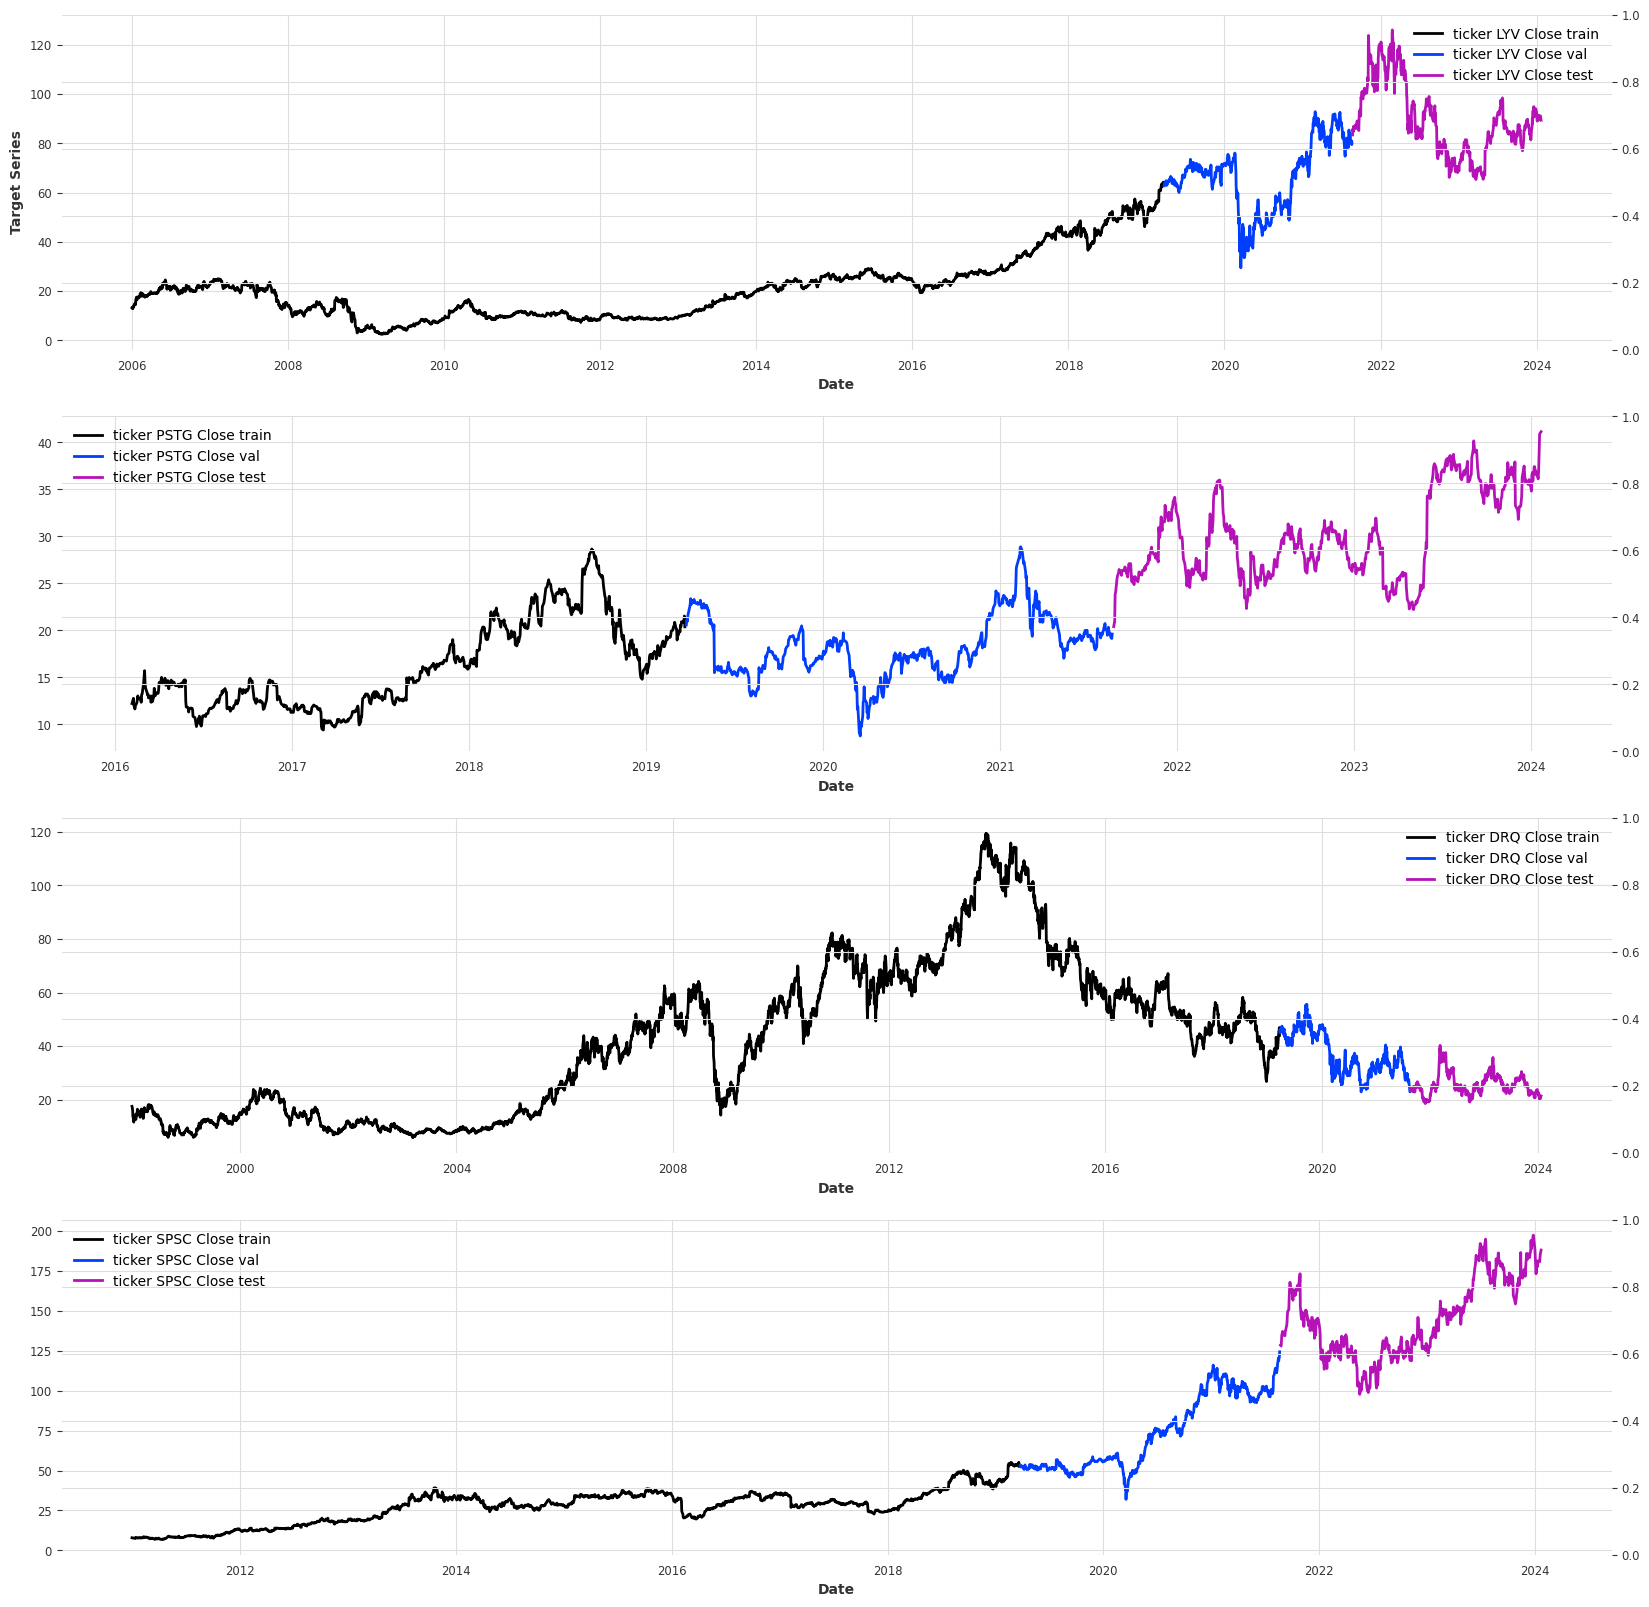

In [ ]:
import matplotlib.pyplot as plt

# plot sample of target series
fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 20))
axes2 = {}
for i in range(n_plot_samples):
    axes2[i] = axes[i].twinx()

for i,t in enumerate(target_series.keys()):
    if i > n_plot_samples-1:
        break

    train_series[t]['Close'].plot(label=f'ticker {t} Close train', ax=axes[i])
#    train_series[t]['Volume'].plot(label=f'ticker {t} Volume train', ax=axes2[i])

    val_series[t]['Close'].plot(label=f'ticker {t} Close val', ax=axes[i])
#    val_series[t]['Volume'].plot(label=f'ticker {t} Volume val', ax=axes2[i])

    test_series[t]['Close'].plot(label=f'ticker {t} Close test', ax=axes[i])
#    test_series[t]['Volume'].plot(label=f'ticker {t} Volume test', ax=axes2[i])

axes[0].set_ylabel('Target Series')


Show seasonalities

Text(0, 0.5, 'Seasonality')

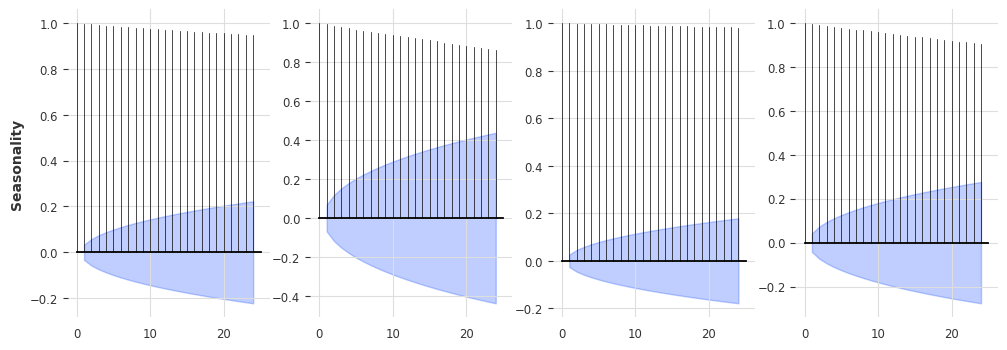

In [ ]:
from darts.utils.statistics import plot_acf, check_seasonality

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i >= n_plot_samples:
        break
    plot_acf(train_series[t]['Close'], alpha=0.05, axis=axes[i])

axes[0].set_ylabel('Seasonality')



## Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [ ]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
# scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'future': [lambda idx: (idx.year % 4)]},  # signal proximity to US election years, which is known to have significance to market cycles.
    # "transformer": scaler
}



Model hyperparameter selection

In [ ]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 2.24e-4,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    # "accelerator": "auto",
    "accelerator": "gpu", 
    "accelerator": "gpu",
    "devices": [0],
    # "auto_select_gpus": True,
    "callbacks": [],
}

# pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1, "auto_select_gpus": True}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 512, # 256,
    "random_state": 42,
}

In [ ]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  if torch.cuda.is_available():
    map_location="cuda"
    # utilize CUDA tensor cores with bfloat16
    # https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
    torch.set_float32_matmul_precision('medium') #  | 'high'
  else:
    map_location="cpu"
  model = TiDEModel.load(saved_model_name, map_location=map_location)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  # using TiDE hyperparameters from Table 8 in section B.3 of the original paper
  # https://arxiv.org/pdf/2304.08424.pdf
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      add_encoders=None, # encoders,
      hidden_size=512,
      num_encoder_layers=2,
      num_decoder_layers=2,
      decoder_output_dim=32,
      temporal_decoder_hidden=128,
      dropout=0.2,
      use_layer_norm=True,
      use_reversible_instance_norm=True,
      n_epochs=n_epochs,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
      log_tensorboard=True,
      nr_epochs_val_period=1
  )
  


Loading saved model


In [ ]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [ ]:
targets_list = [series for ticker, series in sorted(target_series.items())]
target_train_list = [series for ticker, series in sorted(train_series.items())]
print(len(target_train_list))
target_val_list = [series for ticker, series in sorted(val_series.items())]
print(len(target_val_list))
target_test_list = [series for ticker, series in sorted(test_series.items())]
print(len(target_test_list))
past_cov_list = [series for ticker, series in sorted(past_covariates_train.items())]
print(len(past_cov_list))
past_cov_val_list = [series for ticker, series in sorted(past_covariates_val.items())]
print(len(past_cov_val_list))
past_cov_test_list = [series for ticker, series in sorted(past_covariates_test.items())]
print(len(past_cov_test_list))
future_cov_list = [series for ticker, series in sorted(future_covariates.items())]
print(len(future_cov_list))


89
89
89
89
89
89
89


In [ ]:
type(target_train_list[0])

darts.timeseries.TimeSeries

In [ ]:
print(len(target_train_list[0].time_index))
print(len(past_cov_list[0].time_index))

print(len(target_val_list[0].time_index))
print(len(past_cov_val_list[0].time_index))

print(len(target_test_list[0].time_index))
print(len(past_cov_test_list[0].time_index))

print(len(future_cov_list[0].time_index))


5277
6126
630
630
631
631
6538


In [ ]:
target_train_list[0].pd_dataframe()

component        Open      Close
Date                            
1998-12-31   2.194444   2.416667
1999-01-01   2.333333   2.450521
1999-01-04   2.472222   2.484375
1999-01-05   2.388889   2.388889
1999-01-06   2.333333   2.388889
...               ...        ...
2019-03-18  32.880001  32.840000
2019-03-19  32.970001  32.360001
2019-03-20  32.299999  31.980000
2019-03-21  31.940001  32.290001
2019-03-22  32.070000  32.060001

[5277 rows x 2 columns]

In [ ]:
target_train_list[0].start_time(), target_train_list[0].end_time()

(Timestamp('1998-12-31 00:00:00'), Timestamp('2019-03-22 00:00:00'))

In [ ]:
past_cov_list[0].pd_dataframe().columns

Index(['High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       ...
       '^NDX_Low', '^NDX_Close', '^NDX_Adj Close', '^NDX_Volume', '^SPX_Open',
       '^SPX_High', '^SPX_Low', '^SPX_Close', '^SPX_Adj Close', '^SPX_Volume'],
      dtype='object', name='component', length=137)

In [ ]:
past_cov_list[0].pd_dataframe()

component        High        Low  Adj Close     Volume     eps  epsEstimated  \
Date                                                                           
1995-09-29   2.416667   2.361111   2.416667   237600.0 -0.0007       0.00101   
1995-10-02   2.444444   2.361111   2.361111   256500.0 -1.0000       0.00101   
1995-10-03   2.444444   2.361111   2.444444   548100.0 -1.0000       0.00101   
1995-10-04   2.472222   2.388889   2.416667   281700.0 -1.0000       0.00101   
1995-10-05   2.500000   2.416667   2.458333   432900.0 -1.0000       0.00101   
...               ...        ...        ...        ...     ...           ...   
2019-03-18  32.990002  32.689999  32.840000  1196900.0 -1.0000       0.62000   
2019-03-19  33.049999  32.310001  32.360001  1079600.0 -1.0000       0.62000   
2019-03-20  32.410000  31.940001  31.980000   681100.0 -1.0000       0.62000   
2019-03-21  32.459999  31.850000  32.290001  1345800.0 -1.0000       0.62000   
2019-03-22  32.330002  31.889999  32.060001  1066900.0 -1.0000       0.62000   

component   time   revenue  revenueEstimated  updatedFromDate_day  ...  \
Date                                                               ...   
1995-09-29   1.0  500000.0      2.484000e+08                  4.0  ...   
1995-10-02   0.0      -1.0      2.484000e+08                 -1.0  ...   
1995-10-03   0.0      -1.0      2.484000e+08                 -1.0  ...   
1995-10-04   0.0      -1.0      2.484000e+08                 -1.0  ...   
1995-10-05   0.0      -1.0      2.484000e+08                 -1.0  ...   
...          ...       ...               ...                  ...  ...   
2019-03-18   1.0      -1.0      1.275880e+09                 -1.0  ...   
2019-03-19   1.0      -1.0      1.275880e+09                 -1.0  ...   
2019-03-20   1.0      -1.0      1.275880e+09                 -1.0  ...   
2019-03-21   1.0      -1.0      1.275880e+09                 -1.0  ...   
2019-03-22   1.0      -1.0      1.275880e+09                 -1.0  ...   

component      ^NDX_Low   ^NDX_Close  ^NDX_Adj Close   ^NDX_Volume  \
Date                                                                 
1995-09-29   584.929993   585.080017      585.080017  4.635800e+08   
1995-10-02   573.169983   573.869995      573.869995  3.937600e+08   
1995-10-03   563.950012   573.159973      573.159973  4.560000e+08   
1995-10-04   557.429993   558.989990      558.989990  3.863900e+08   
1995-10-05   556.609985   572.750000      572.750000  4.565600e+08   
...                 ...          ...             ...           ...   
2019-03-18  7293.850098  7326.279785     7326.279785  2.302140e+09   
2019-03-19  7321.930176  7349.279785     7349.279785  2.457920e+09   
2019-03-20  7318.419922  7380.750000     7380.750000  2.464230e+09   
2019-03-21  7356.939941  7493.270020     7493.270020  2.502810e+09   
2019-03-22  7323.520020  7326.060059     7326.060059  2.504740e+09   

component     ^SPX_Open    ^SPX_High     ^SPX_Low   ^SPX_Close  \
Date                                                             
1995-09-29   585.869995   587.609985   584.000000   584.409973   
1995-10-02   584.409973   585.049988   580.539978   581.719971   
1995-10-03   581.719971   582.340027   578.479980   582.340027   
1995-10-04   582.340027   582.340027   579.909973   581.469971   
1995-10-05   581.469971   582.630005   579.580017   582.630005   
...                 ...          ...          ...          ...   
2019-03-18  2822.610107  2835.409912  2821.989990  2832.939941   
2019-03-19  2840.760010  2852.419922  2823.270020  2832.570068   
2019-03-20  2831.340088  2843.540039  2812.429932  2824.229980   
2019-03-21  2819.719971  2860.310059  2817.379883  2854.879883   
2019-03-22  2844.520020  2846.159912  2800.469971  2800.709961   

component   ^SPX_Adj Close   ^SPX_Volume  
Date                                      
1995-09-29      584.409973  3.352500e+08  
1995-10-02      581.719971  3.049900e+08  
1995-10-03      582.340027  3.859400e+08  
1995-10-04 

In [ ]:
past_cov_list[0].start_time(), past_cov_list[0].end_time()

(Timestamp('1995-09-29 00:00:00'), Timestamp('2019-03-22 00:00:00'))

In [ ]:
target_val_list[0].start_time(), target_val_list[0].end_time()

(Timestamp('2019-03-25 00:00:00'), Timestamp('2021-08-20 00:00:00'))

In [ ]:
past_cov_val_list[0].start_time(), past_cov_val_list[0].end_time()

(Timestamp('2019-03-25 00:00:00'), Timestamp('2021-08-20 00:00:00'))

In [ ]:
target_test_list[0].start_time(), target_test_list[0].end_time()

(Timestamp('2021-08-23 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [ ]:
past_cov_test_list[0].start_time(), past_cov_test_list[0].end_time()

(Timestamp('2021-08-23 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [ ]:
n_holidays = future_cov_list[0].pd_dataframe().sum()
n_holidays

component
holidays                               2.550000e+02
estimatedRevenueLow_p_1                6.157132e+12
estimatedRevenueHigh_p_1               7.260769e+12
estimatedRevenueAvg_p_1                6.638998e+12
estimatedEbitdaLow_p_1                 9.358011e+11
                                           ...     
numberAnalystEstimatedRevenue_p_2_1    2.124500e+04
numberAnalystsEstimatedEps_p_2_1       3.633700e+04
fiscalDateEnding_day_p_2_1             2.026780e+05
fiscalDateEnding_month_p_2_1           7.845600e+04
fiscalDateEnding_year_p_2_1            1.315596e+07
Length: 139, dtype: float64

In [ ]:
future_cov_list[0].columns

Index(['holidays', 'estimatedRevenueLow_p_1', 'estimatedRevenueHigh_p_1',
       'estimatedRevenueAvg_p_1', 'estimatedEbitdaLow_p_1',
       'estimatedEbitdaHigh_p_1', 'estimatedEbitdaAvg_p_1',
       'estimatedEbitLow_p_1', 'estimatedEbitHigh_p_1', 'estimatedEbitAvg_p_1',
       ...
       'estimatedSgaExpenseHigh_p_2_1', 'estimatedSgaExpenseAvg_p_2_1',
       'estimatedEpsAvg_p_2_1', 'estimatedEpsHigh_p_2_1',
       'estimatedEpsLow_p_2_1', 'numberAnalystEstimatedRevenue_p_2_1',
       'numberAnalystsEstimatedEps_p_2_1', 'fiscalDateEnding_day_p_2_1',
       'fiscalDateEnding_month_p_2_1', 'fiscalDateEnding_year_p_2_1'],
      dtype='object', name='component', length=139)

In [ ]:
future_cov_list[0].start_time(), future_cov_list[0].end_time()

(Timestamp('1998-12-31 00:00:00'), Timestamp('2024-01-22 00:00:00'))

### Run model training loop

In [ ]:
# train model
# for i in range(100):
model.fit(target_train_list, epochs=n_epochs, past_covariates=past_cov_list, future_covariates=future_cov_list, 
          val_series=target_val_list, val_past_covariates=past_cov_val_list, val_future_covariates=future_cov_list,
          verbose=True, num_loader_workers=4, ) # num_loader_workers recommended at 4*n_GPUs
          # val_series=target_val_list[0]) # , val_future_covariates=future_cov_list[0]) 



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 4     
4 | past_cov_projection   | _ResidualBlock   | 73.3 K
5 | future_cov_projection | _ResidualBlock   | 74.3 K
6 | encoders              | Sequential       | 6.4 M 
7 | decoders              | Sequential       | 10.7 M
8 | temporal_decoder      | _ResidualBlock   | 34.4 K
9 | lookback_skip         | Linear           | 148 K 
-----------------------------------------------------------
17.4 M    Trainable params
0         Non-trainable params
17.4 M    Total params
69.761    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

: 

### Save model checkpoint

In [ ]:
# save model checkpoint
model.save(saved_model_name)


In [ ]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
# pred = model.predict(pred_horizon, series=target_train_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)

## Test Model Forecasting

In [ ]:
# pred[0]

In [ ]:
# pred[0].gaps()

In [ ]:
#pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
#pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred2

### Plot several forecasts at various future starting points

In [ ]:
import matplotlib.dates as mdates

def get_val_start_list():
    val_start_list = []
    for t, target in sorted(target_series.items()):
        val_start_list.append(val_start[t])
    return val_start_list


def get_test_start_list():
    val_test_list = []
    for t, target in sorted(target_series.items()):
        val_test_list.append(test_start[t])
    return val_test_list


def get_pred_start(start_times=None, offset=None):
    pred_start = {}
    bdays_offset = BDay(n=train_history + offset*pred_horizon)
    for t, start_time in start_times.items():
        pred_start[t] = start_time + bdays_offset
    return pred_start    

def get_pred_list(pred_start=None):
    pred_list = []
    for t, target in sorted(target_series.items()):
        pred_series = target.slice(target.start_time(), pred_start[t]-pd.Timedelta(days=1))
        pred_list.append(pred_series)
    return pred_list


def get_past_cov_list(pred_start=None):
    past_cov_list = []
    for t, past_cov in sorted(past_covariates.items()):
        past_covs_sliced = past_cov.slice(past_cov.start_time(), pred_start[t]-pd.Timedelta(days=1))
        past_cov_list.append(past_covs_sliced)
    return past_cov_list

def get_pred(pred_list=None, past_cov_list=None):
    #pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
    pred = model.predict(pred_horizon, series=pred_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list, num_loader_workers=4)
    return pred

pred_test_outputs = []
# get predictions at several points in time over the validation set
for w in range(3):
    pred_start = get_pred_start(start_times=test_start, offset=w)
    pred_list = get_pred_list(pred_start)    
    past_cov_list = get_past_cov_list(pred_start)
    # print(f'pred_list: \n{pred_list}')
    pred = get_pred(pred_list=pred_list, past_cov_list=past_cov_list)
    pred_test_outputs.append(pred)


pred_val_outputs = []
# get predictions at several points in time over the validation set
for w in range(10):
    pred_start = get_pred_start(start_times=val_start, offset=w)
    pred_list = get_pred_list(pred_start)    
    past_cov_list = get_past_cov_list(pred_start)
    # print(f'pred_list: \n{pred_list}')
    pred = get_pred(pred_list=pred_list, past_cov_list=past_cov_list)
    pred_val_outputs.append(pred)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

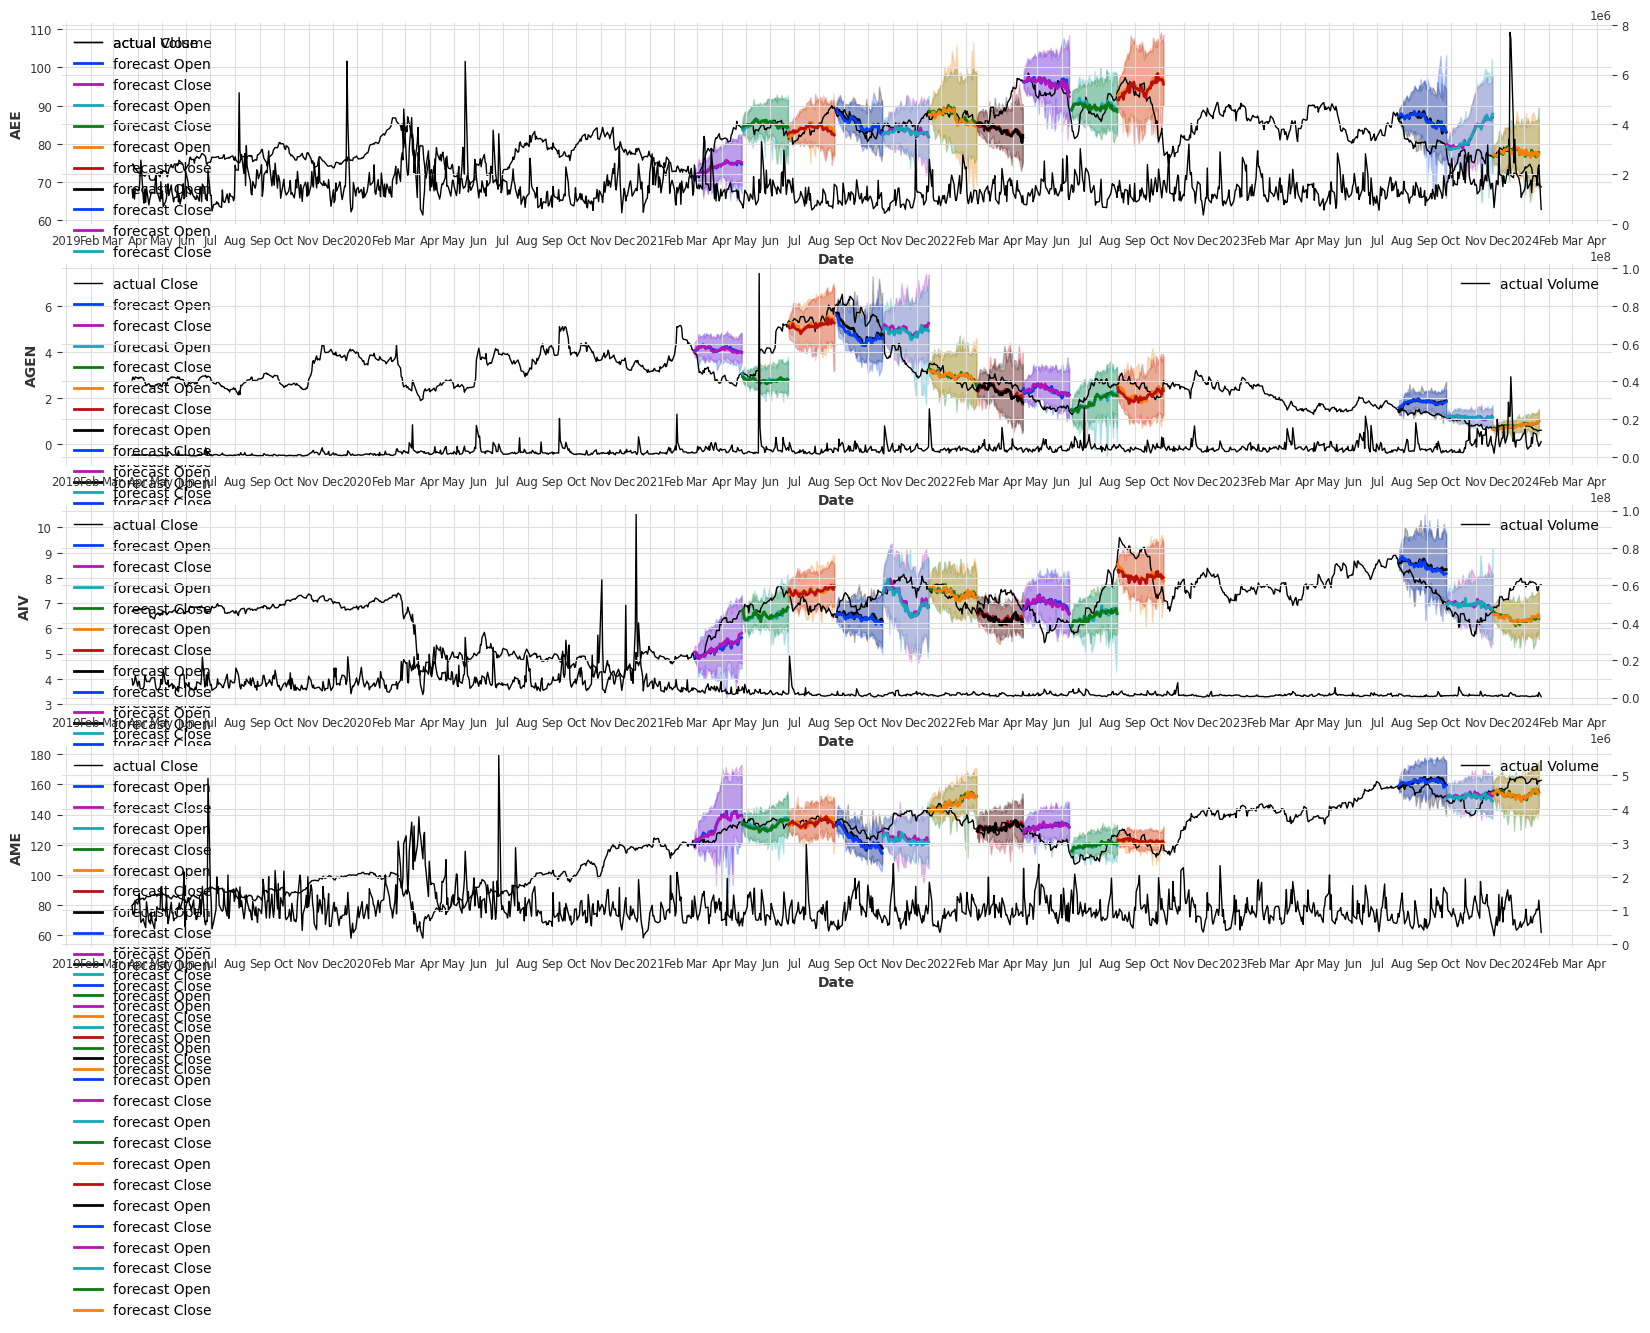

In [ ]:
# select a reasonable range of train and val data points for convenient visualization of results
actual = {}

def plot_actual():
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            tsliced = target_series[t]
            actual[t] = tsliced.slice(val_start[t], target.end_time())
            # ax = actual[t]['Open'].plot(label='actual Open', linewidth=1, ax=axes[i])
            ax = actual[t]['Close'].plot(label='actual Close', linewidth=1, ax=axes[i])
            vol = past_covariates[t]['Volume'].slice(val_start[t], target.end_time())
            vol.plot(label='actual Volume', linewidth=1, ax=axes2[i])


def plot_pred(pred_out=None, past_cov_list=None):
    #pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            ax = pred_out[i]['Open'].plot(label=f'forecast Open', linewidth=2, ax=axes[i])
            ax = pred_out[i]['Close'].plot(label=f'forecast Close', linewidth=2, ax=axes[i])
            plt.legend()
            # Major ticks every half year, minor ticks every month,
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            ax.grid(True)
            ax.set_ylabel(f'{t}')



fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 12))
axes2 = {}
for i in range(n_plot_samples):
    axes2[i] = axes[i].twinx()

plot_actual()

# plot predictions at several points in time over the validation set
# plot_pred(pred_outputs=pred_outputs, past_cov_list=past_cov_list)
for pred_out in pred_val_outputs:
    plot_pred(pred_out=pred_out, past_cov_list=past_cov_list)

for pred_out in pred_test_outputs:
    plot_pred(pred_out=pred_out, past_cov_list=past_cov_list)


### Backtest Model


In [ ]:
# Backtest model on the full range of test data
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the val portion of the flow series, with a forecast_horizon:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          overlap_end=True,
                                          stride=forecast_horizon // 2,
                                          last_points_only=False,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 4, 'n_jobs': -1}
                                          )
    
    return backtest


In [ ]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
# forecast_start = test_start-BDay(n=30)
pred_start_list = get_test_start_list()
forecast_start = pred_start_list[0]-BDay(n=30)
forecast_horizon = pred_horizon # pred_horizon

backtest = eval_model(model=model, series=targets_list[0], start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_cov_list[0], future_covariates=future_cov_list[0])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
forecast_start

Timestamp('2021-07-12 00:00:00')

In [ ]:
forecast_horizon

42

In [ ]:
targets_list[0].start_time()

Timestamp('1998-01-02 00:00:00')

In [ ]:
backtest[0]

<TimeSeries (DataArray) (Date: 42, component: 2, sample: 500)>
array([[[82.63453295, 81.56214022, 82.40113089, ..., 81.85996506,
         81.78113362, 81.98095176],
        [81.33703724, 82.47676322, 79.83613983, ..., 82.39709112,
         82.39812016, 82.44272642]],

       [[81.69872606, 84.71415498, 81.13932943, ..., 81.7394271 ,
         82.3276137 , 80.99614676],
        [83.40011039, 80.50686707, 81.41358327, ..., 82.43171016,
         82.45847195, 82.32820787]],

       [[82.84890702, 80.52171607, 82.02719363, ..., 79.38985983,
         80.71271023, 81.69206424],
        [84.50015861, 77.98337508, 84.55945071, ..., 82.47705284,
         82.52366866, 80.48443747]],

       ...,

       [[87.47774038, 79.56435995, 82.51439356, ..., 80.62099421,
         85.43795623, 81.37689384],
        [77.53555687, 81.95014572, 80.44136716, ..., 84.24807818,
         84.64814949, 80.89961675]],

       [[85.33668678, 81.25961659, 91.22412497, ..., 80.33687516,
         86.48917689, 64.44300214],
        [80.55540379, 80.75382224, 72.6706993 , ..., 78.6890726 ,
         84.54194712, 84.93883087]],

       [[82.12049   , 81.82892242, 78.01726239, ..., 84.45219355,
         86.68904747, 81.39054353],
        [81.26195225, 88.81541139, 81.54772329, ..., 65.83410807,
         87.13106579, 84.80125155]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2021-07-12 2021-07-13 ... 2021-09-07
  * component  (component) object 'Open' 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


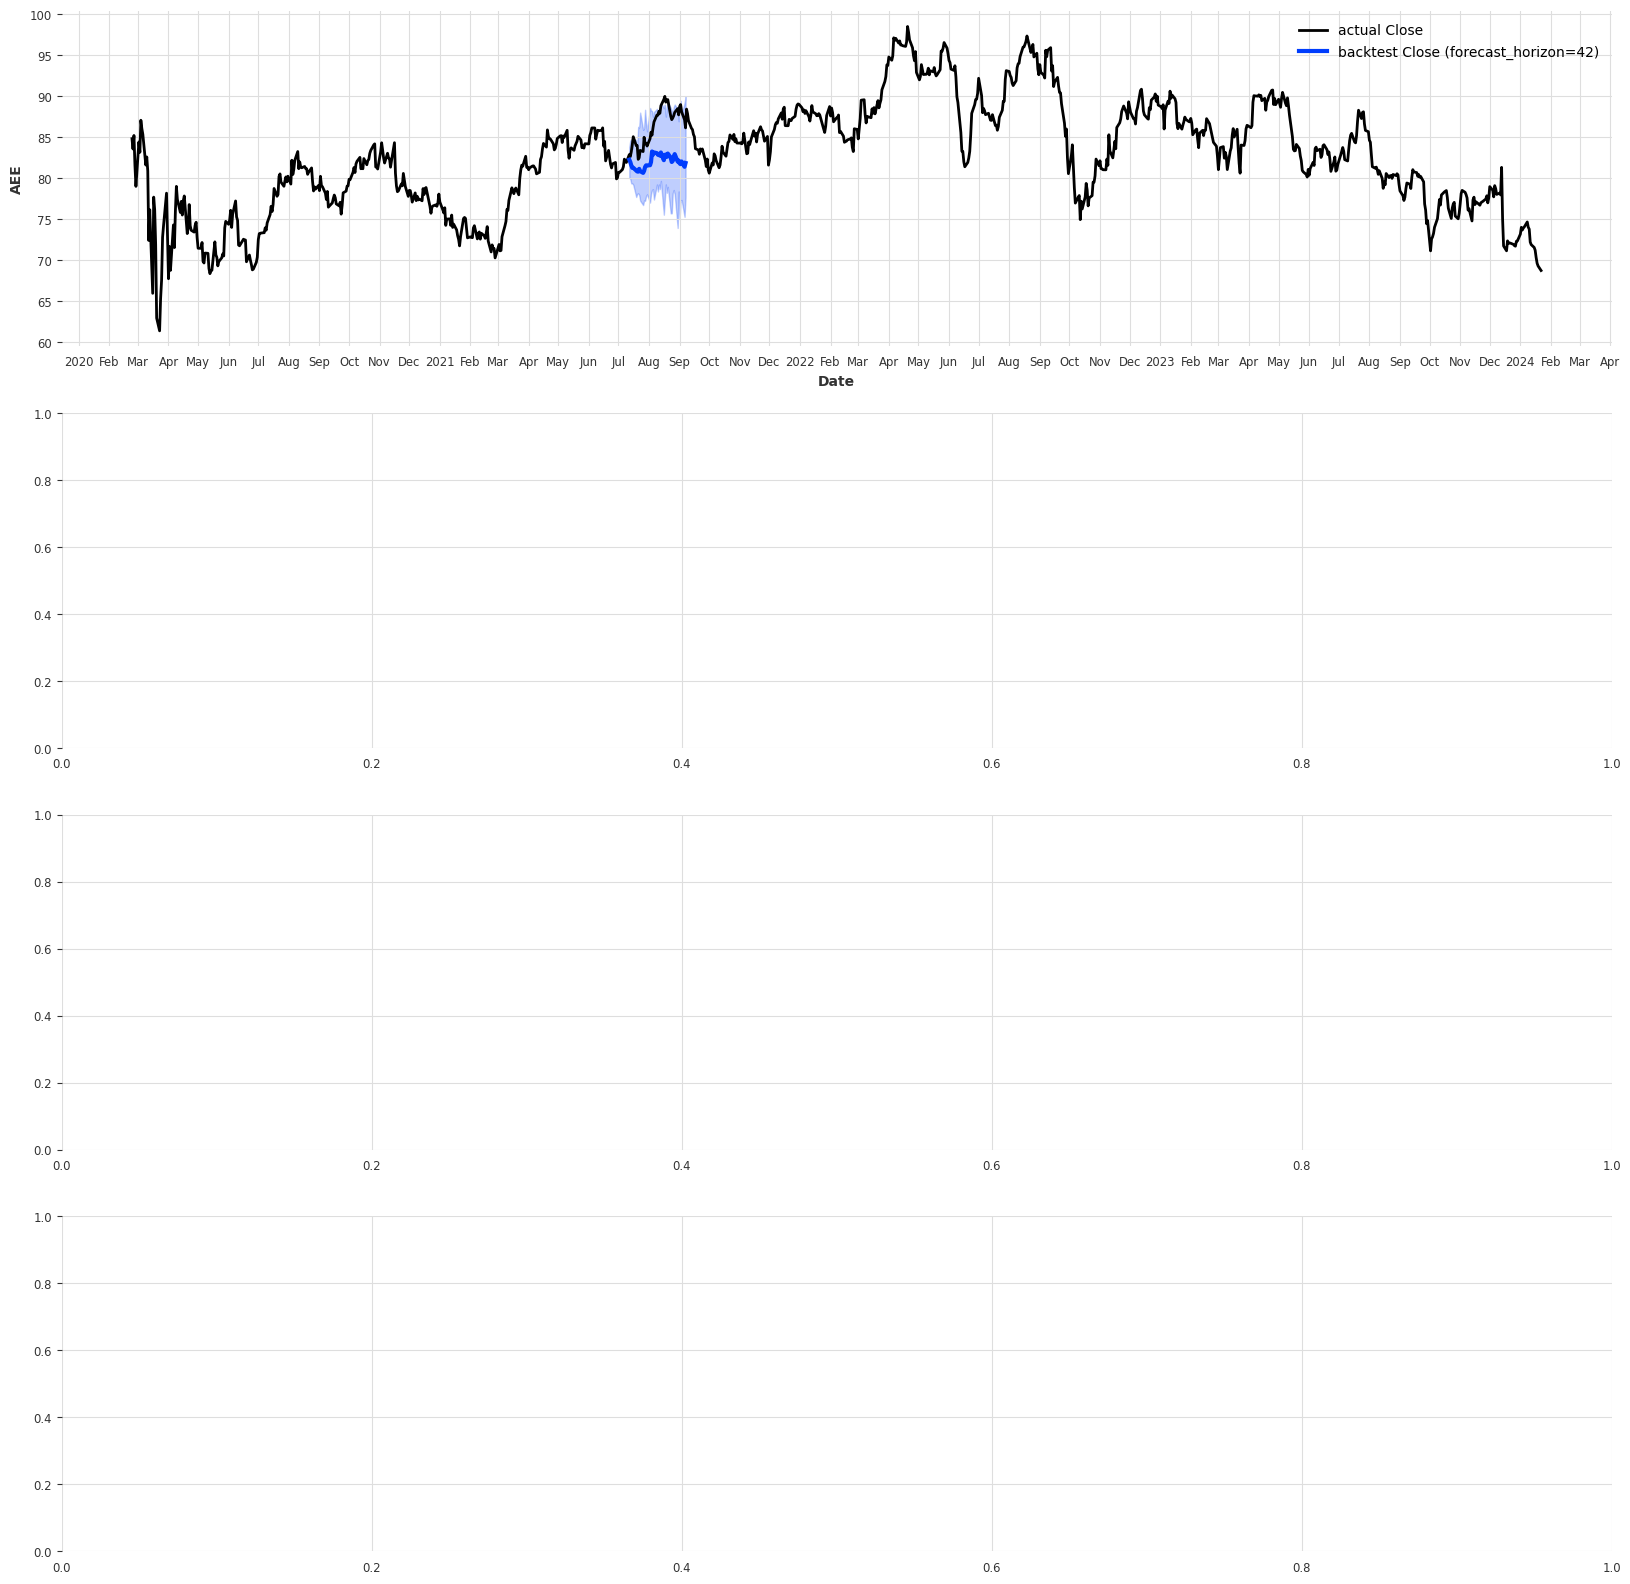

In [ ]:


fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 20))
# axes2 = {}
# for i in range(n_plot_samples):
#    axes2[i] = axes[i].twinx()

for i,t in enumerate(sorted(train_series.keys())):
    # if i < n_plot_samples:
    if i == 0:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(forecast_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t]['Close'].plot(label='actual Close', linewidth=2, ax=axes[i])
        # actual[t]['Volume'].plot(label='actual Volume', ax=axes2[i])
        backtest[i]['Close'].plot(label=f'backtest Close (forecast_horizon={forecast_horizon})', linewidth=3, ax=axes[i])
        # backtest[i]['Volume'].plot(label=f'backtest Volume (forecast_horizon={forecast_horizon})', linewidth=1, ax=axes2[i])
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13), interval=1))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')



In [ ]:
assert len(target_train_list[0].gaps()) == 0 # :n_plot_samples]

In [ ]:
len(target_train_list[0])

5536

In [ ]:
len(target_train_list[0][:len(backtest[0])])

42

In [ ]:
assert len(backtest[0].gaps()) == 0

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


In [ ]:
len(backtest[0])

42

In [ ]:
print('Backtest RMSE = {}'.format(rmse(target_train_list[0], backtest[0])))


Backtest RMSE = nan


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
